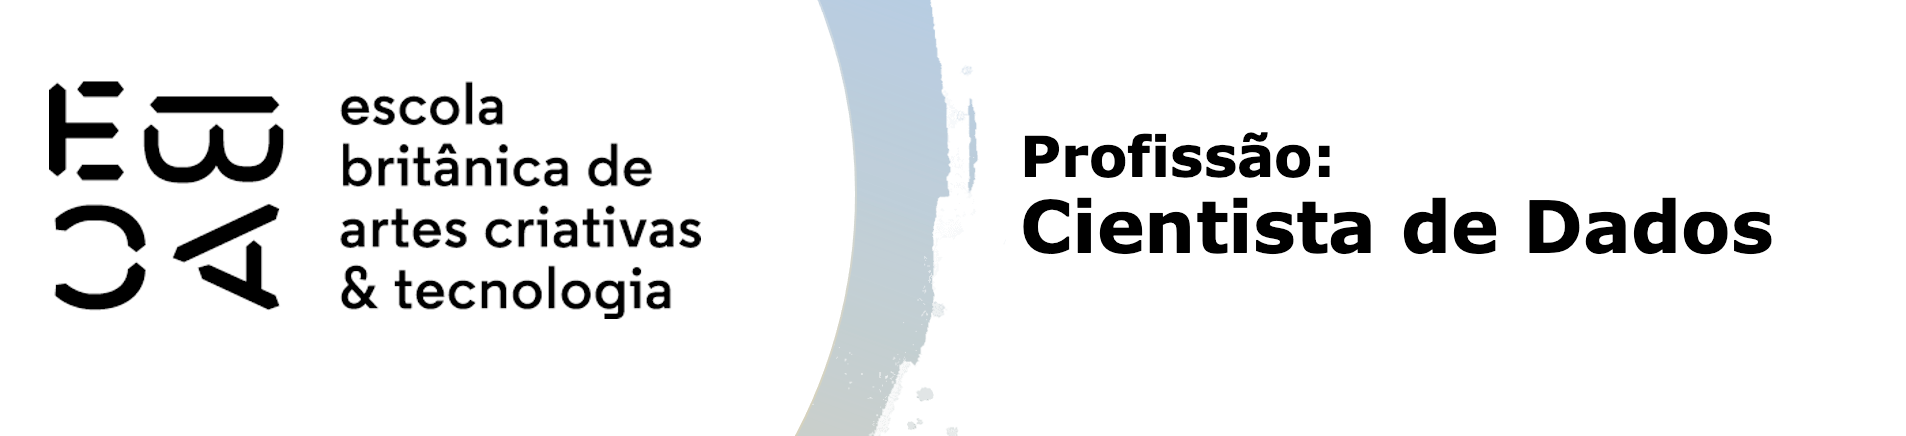

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [101]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pycaret

from scipy.stats import chi2_contingency
from scipy.stats import ks_2samp
from scipy import stats

from pycaret.datasets import get_data
from pycaret.classification import setup, compare_models, create_model, tune_model, evaluate_model, interpret_model, predict_model, save_model, load_model

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.calibration import calibration_curve
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score

In [ ]:
'''# Carrega um conjunto de dados de exemplo
data = get_data('iris')

# Configura o ambiente de classificação
clf = setup(data, target='species')

# Compara modelos
best_model = compare_models()'''

In [3]:
df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [4]:
# Removendo a coluna index, que não terá uso nas análises
df = df.drop(columns=['index'])

# Capturando a última data
data_max = df['data_ref'].max()
# Esse DataFrame vai conter a data máxima menos 3 meses, ou seja, os ultimos 3 meses.
df_oot = df[df['data_ref'] >= data_max - pd.DateOffset(months=3)]
# Esse DataFrame vai conter tudo, menos os ultimos 3 meses de dados (máximo - 3 meses e "<" para pegar menos disso)
# 2015 até 2016
df_modelar = df[df['data_ref'] < data_max - pd.DateOffset(months=3)]

# Removendo o data_ref que vai ser usado apenas para fatiar os dados pelo tempo
'''df_oot = df_oot.drop(columns=['data_ref'])
df_modelar = df_modelar.drop(columns=['data_ref'])'''

"df_oot = df_oot.drop(columns=['data_ref'])\ndf_modelar = df_modelar.drop(columns=['data_ref'])"

## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [5]:
# Verificando os tipos das colunas
df_modelar.dtypes

data_ref                 datetime64[ns]
sexo                             object
posse_de_veiculo                 object
posse_de_imovel                  object
qtd_filhos                        int64
tipo_renda                       object
educacao                         object
estado_civil                     object
tipo_residencia                  object
idade                             int64
tempo_emprego                   float64
qt_pessoas_residencia           float64
renda                           float64
mau                                bool
dtype: object

In [6]:
# Criando uma lista para cada tipo de variável
qualitativas = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos', 'tipo_renda', 'educacao',
               'estado_civil', 'tipo_residencia', 'qt_pessoas_residencia']
quantitativas = ['idade', 'tempo_emprego', 'renda']

In [7]:
# Verificando a quantidade de tipos de valores únicos em cada coluna
df_modelar.nunique()

data_ref                     11
sexo                          2
posse_de_veiculo              2
posse_de_imovel               2
qtd_filhos                    8
tipo_renda                    5
educacao                      5
estado_civil                  5
tipo_residencia               6
idade                        47
tempo_emprego              3004
qt_pessoas_residencia         9
renda                    111722
mau                           2
dtype: int64

In [8]:
# Verificando o número de linhas e colunas
df_modelar.shape

(550000, 14)

In [9]:
# Verificando a quantidade de linhas para cada mês
# No caso os dados foram pré-processados para pegar uma quantidade igual de cada mês
linhas_por_mes = df_modelar.resample('M', on='data_ref').size()
linhas_por_mes

data_ref
2015-01-31    50000
2015-02-28    50000
2015-03-31    50000
2015-04-30    50000
2015-05-31    50000
2015-06-30    50000
2015-07-31    50000
2015-08-31    50000
2015-09-30    50000
2015-10-31    50000
2015-11-30    50000
Freq: M, dtype: int64

#### Como o data_ref vai ser usado apenas para acompanhamento temporal, será removido para não interferir nas análises.

In [10]:
# Removendo a coluna data_ref
df_modelar = df_modelar.drop(columns='data_ref')

In [11]:
# Verificando proporção de clientes inadimplentes (mau ou 1)
df_modelar['mau'].value_counts()

False    518213
True      31787
Name: mau, dtype: int64

## Qualitativas

In [12]:
# Criando dicionário para guardar as tabelas de contingencia
contingency_dict = {}

# Percorrendo a lista de qualitativas
for coluna in qualitativas:
    # Criando o crosstab para cada item da lista em conjunto com a coluna resposta
    contingency_table = pd.crosstab(df_modelar[coluna], df_modelar['mau'])
    # Populando o dicionário onde chave é o nome da coluna e o valor é o crosstab
    contingency_dict[coluna] = contingency_table
    
    # Calcula a proporção e adiciona como uma nova coluna na tabela de contingência
    total_por_linha = contingency_table.sum(axis=1)
    contingency_table['proporcao_bom'] = contingency_table[False] / total_por_linha
    contingency_table['proporcao_mau'] = contingency_table[True] / total_por_linha
    

#### Abaixo é percorrido cada item da lista de tabelas de contingência para criar gráficos, cada gráfico mostra a proporção de adimplentes/inadimplentes de cada variável qualitativa.
<br>

#### É possível perceber que a quantidade de pessoas na residência não tem nenhum valor de inadimplentes no valor de 7 pessoas devido a baixa amostra desses valores, para isso será necessário unir com outros valores semelhantes e de baixa amostra.

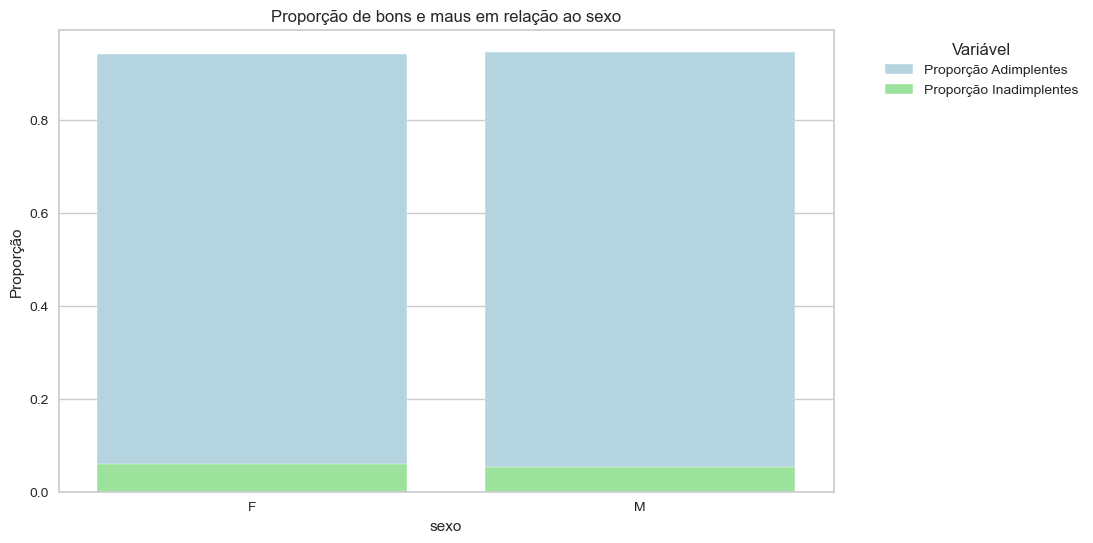

mau,False,True,proporcao_bom,proporcao_mau
sexo,,,,
F,348064,22063,0.940391,0.059609
M,170149,9724,0.945940,0.054060


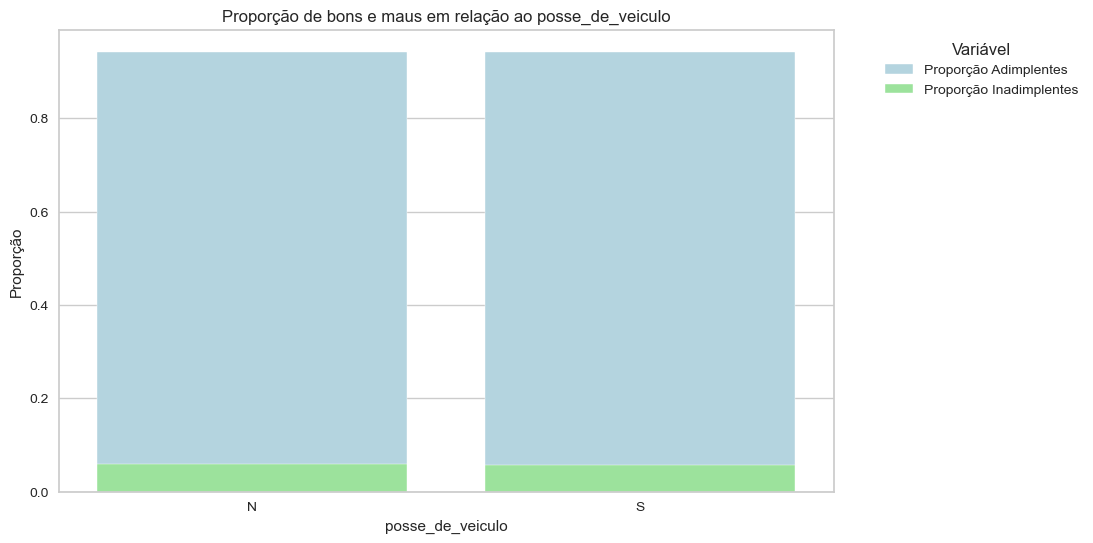

mau,False,True,proporcao_bom,proporcao_mau
posse_de_veiculo,,,,
N,316160,19495,0.941920,0.058080
S,202053,12292,0.942653,0.057347


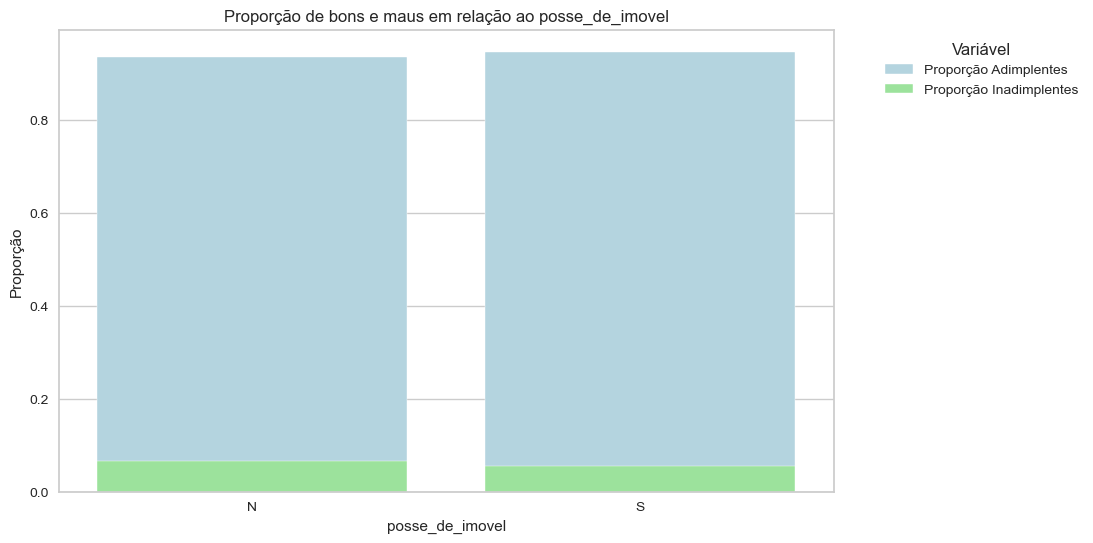

mau,False,True,proporcao_bom,proporcao_mau
posse_de_imovel,,,,
N,168867,11860,0.934376,0.065624
S,349346,19927,0.946037,0.053963


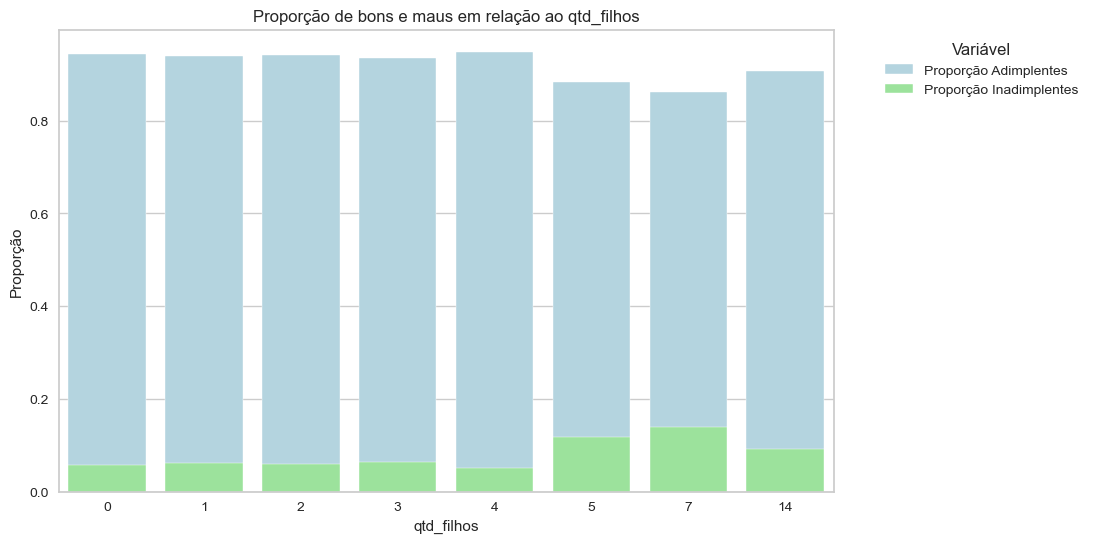

mau,False,True,proporcao_bom,proporcao_mau
qtd_filhos,,,,
0,357969,21439,0.943494,0.056506
1,105299,6859,0.938845,0.061155
2,48029,3010,0.941025,0.058975
3,5993,415,0.935237,0.064763
4,742,40,0.948849,0.051151
5,60,8,0.882353,0.117647
7,62,10,0.861111,0.138889
14,59,6,0.907692,0.092308


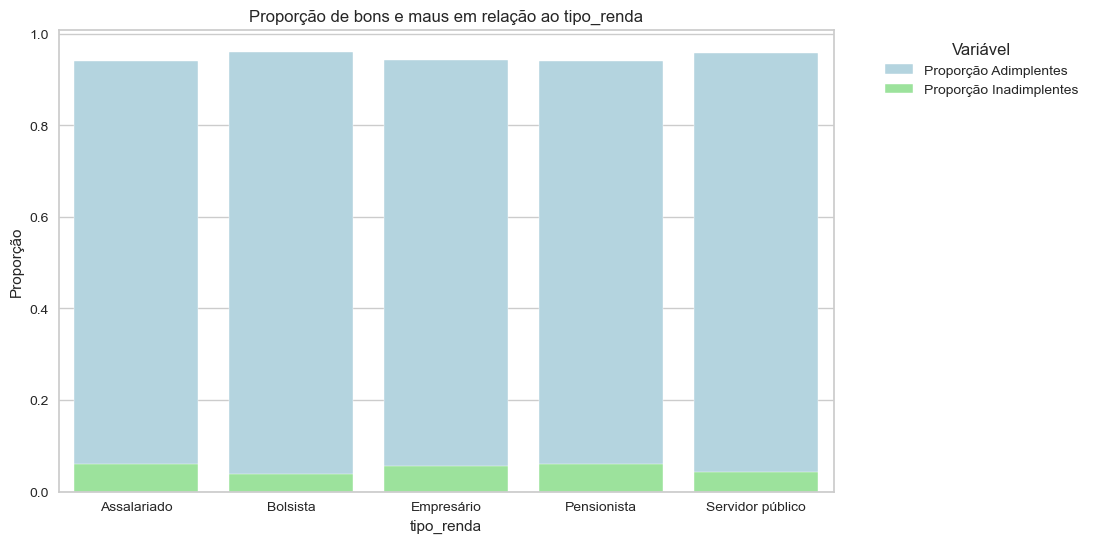

mau,False,True,proporcao_bom,proporcao_mau
tipo_renda,,,,
Assalariado,265681,17048,0.939702,0.060298
Bolsista,248,10,0.961240,0.038760
Empresário,119389,7135,0.943608,0.056392
Pensionista,87128,5593,0.939679,0.060321
Servidor público,45767,2001,0.958110,0.041890


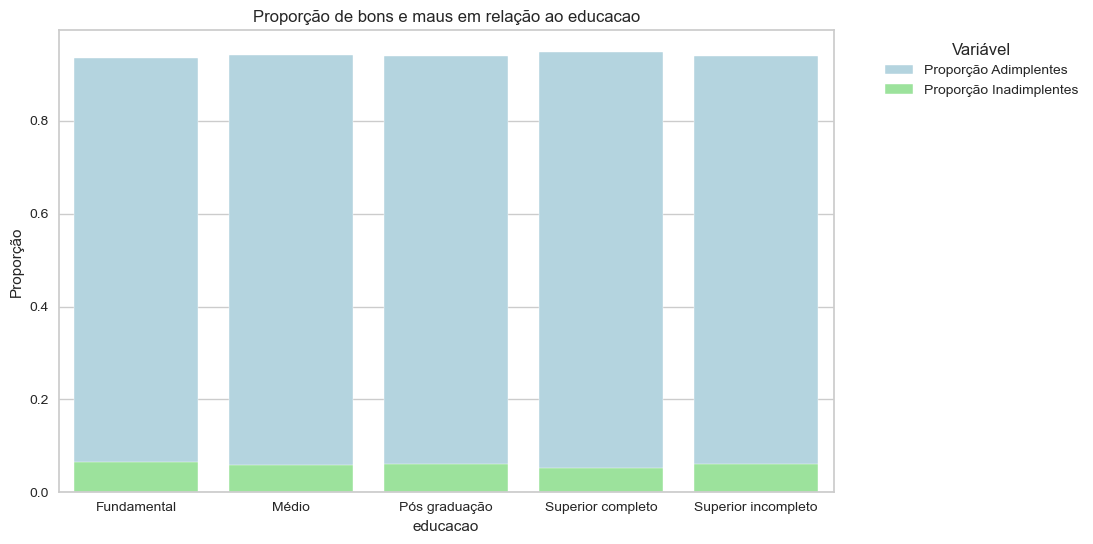

mau,False,True,proporcao_bom,proporcao_mau
educacao,,,,
Fundamental,5914,417,0.934134,0.065866
Médio,349470,22115,0.940485,0.059515
Pós graduação,564,37,0.938436,0.061564
Superior completo,142005,7896,0.947325,0.052675
Superior incompleto,20260,1322,0.938745,0.061255


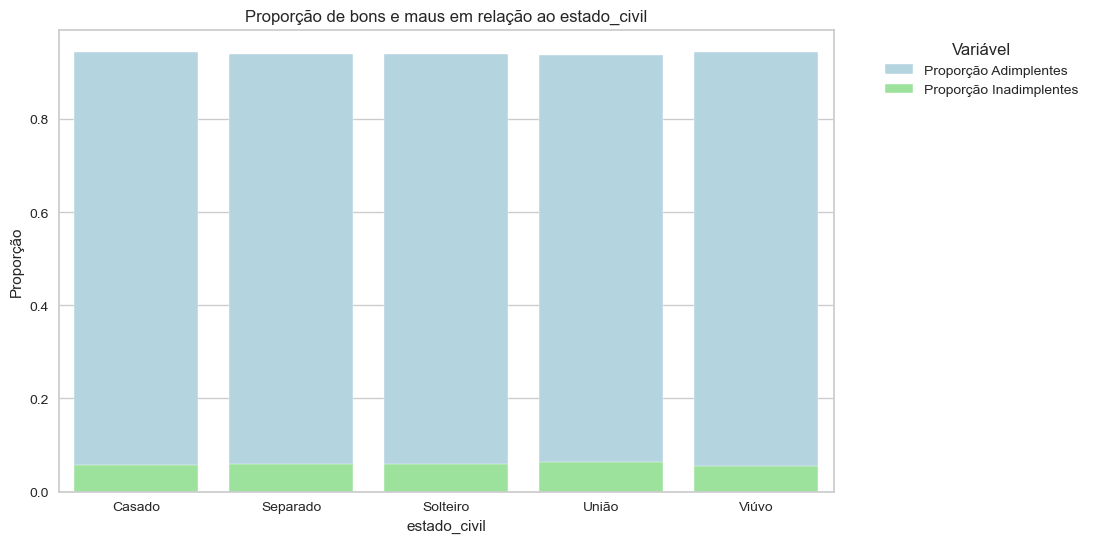

mau,False,True,proporcao_bom,proporcao_mau
estado_civil,,,,
Casado,364299,21939,0.943198,0.056802
Separado,29429,1885,0.939803,0.060197
Solteiro,62974,4010,0.940135,0.059865
União,39540,2671,0.936723,0.063277
Viúvo,21971,1282,0.944867,0.055133


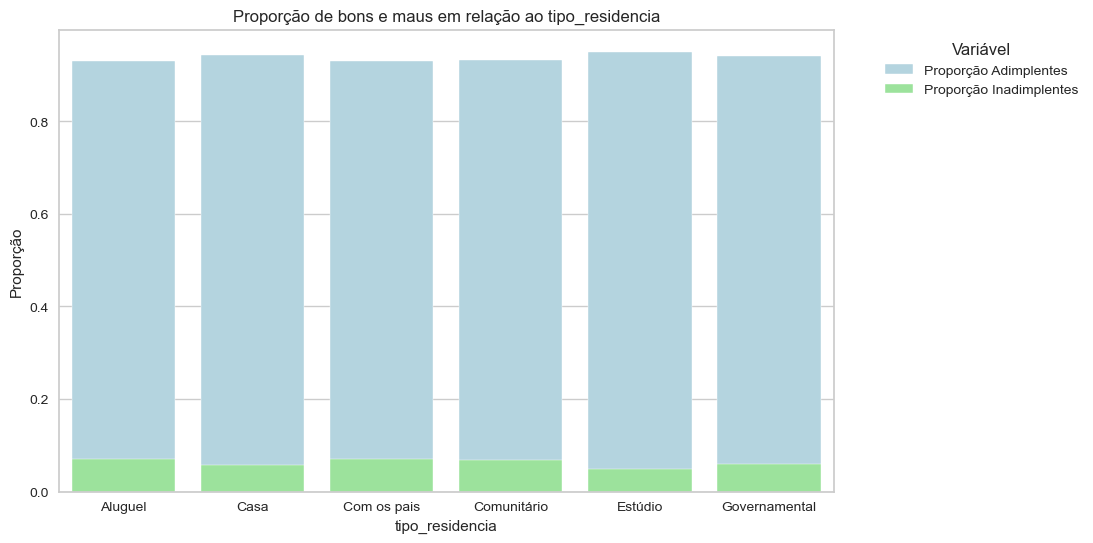

mau,False,True,proporcao_bom,proporcao_mau
tipo_residencia,,,,
Aluguel,6998,529,0.929720,0.070280
Casa,466263,28147,0.943070,0.056930
Com os pais,22792,1727,0.929565,0.070435
Comunitário,2274,164,0.932732,0.067268
Estúdio,3743,195,0.950482,0.049518
Governamental,16143,1025,0.940296,0.059704


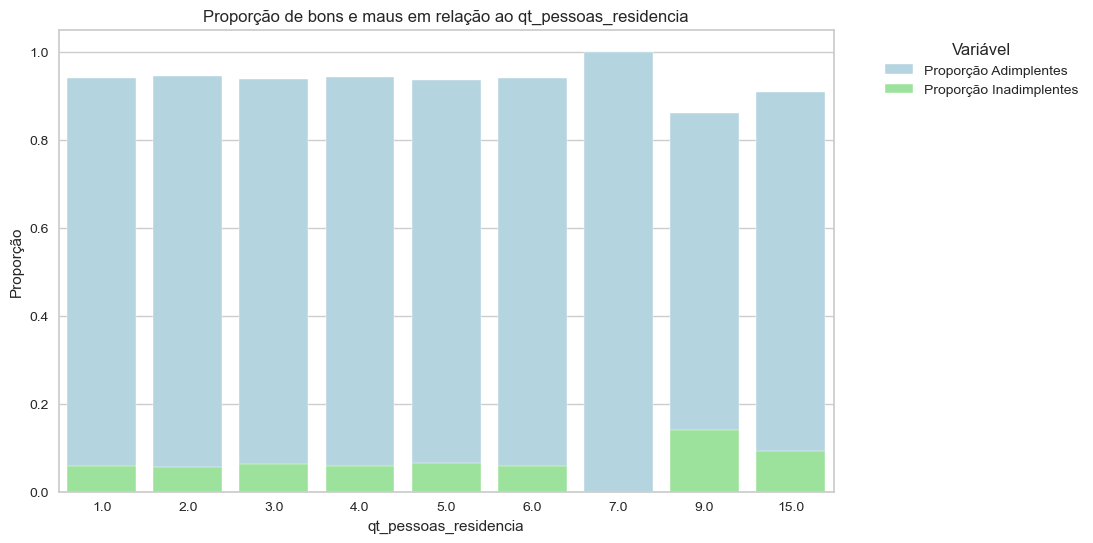

mau,False,True,proporcao_bom,proporcao_mau
qt_pessoas_residencia,,,,
1.0,93640,5872,0.940992,0.059008
2.0,282394,16700,0.944165,0.055835
3.0,89453,5881,0.938312,0.061688
4.0,46092,2870,0.941383,0.058617
5.0,5711,400,0.934544,0.065456
6.0,764,48,0.940887,0.059113
7.0,38,0,1.000000,0.000000
9.0,62,10,0.861111,0.138889
15.0,59,6,0.907692,0.092308


In [13]:
for var in qualitativas:
    
   # Definir o estilo do seaborn
    sns.set_style("whitegrid")

    # Plotar o gráfico de barras
    plt.figure(figsize=(10, 6))
    sns.barplot(x=contingency_dict[var].index, y=contingency_dict[var]['proporcao_bom'], color='lightblue', label='Proporção Adimplentes')
    sns.barplot(x=contingency_dict[var].index, y=contingency_dict[var]['proporcao_mau'], color='lightgreen', label='Proporção Inadimplentes')
    plt.title(f'Proporção de bons e maus em relação ao {var}')
    plt.xlabel(f'{var}')
    plt.ylabel('Proporção')

    plt.legend(title='Variável')
    # Ajustando a posição da legenda
    plt.legend(title='Variável', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()
    
    display(contingency_dict[var])
    print('\n\n\n\n')

## Quantitativas

#### Na descritiva abaixo já é possível perceber que renda tem outliers devido a sua média comparada a mediana(quartil 50), terceiro quartil, seu max e seu desvio padrão, o tempo_emprego tem valores faltantes.

In [14]:
# Fazendo uma cópia apenas com as colunas quantitativas
df_quantitativa = df_modelar[quantitativas].copy()

# Tive que buscar esse comando para visualizar melhor a coluna renda
pd.options.display.float_format = '{:.2f}'.format # comando para mostrar float com 2 casas decimais

# Verificando média, desvio padrão, minimo, quartis e máximo
df_quantitativa.describe()

,idade,tempo_emprego,renda
count,550000.00,457512.00,550000.00
mean,43.80,7.75,28614.22
std,11.23,6.69,90570.15
min,22.00,0.12,161.86
25%,34.00,3.05,5031.18
50%,43.00,6.05,10572.79
75%,53.00,10.18,22766.99
max,68.00,42.91,4083986.22


In [15]:
# Verificando a quantidade de valores faltantes em tempo_emprego 
# e se tem alguma outra coluna que tem valor faltantes
df_modelar.isnull().sum()

sexo                         0
posse_de_veiculo             0
posse_de_imovel              0
qtd_filhos                   0
tipo_renda                   0
educacao                     0
estado_civil                 0
tipo_residencia              0
idade                        0
tempo_emprego            92488
qt_pessoas_residencia        0
renda                        0
mau                          0
dtype: int64

#### Como foi percebido valores nulos em tempo_emprego, foi criado um DataFrame para tentar entender se foi uma falta de dado ou uma caracteristica desse grupo. Da para perceber que todos valores de tipo_renda são de pensionistas, mas para não atrapalhar as analises, esses faltantes já vão ser tratados com valores médios, pensei também em zerar, pois realmente não teria o tempo de emprego, mas isso iria afetar muito o valor do tempo de emprego em relação a variável resposta e renda.

In [16]:
# Criando um DataFrame de valores nulos
df_nulos = df_modelar[df_modelar['tempo_emprego'].isnull()]
df_nulos

,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
9,F,N,S,0,Pensionista,Médio,Casado,Casa,60,NaN,2.00,1929.08,True
10,F,N,S,0,Pensionista,Médio,Solteiro,Casa,66,NaN,1.00,4825.49,True
12,F,N,S,0,Pensionista,Médio,Casado,Casa,57,NaN,2.00,3536.33,False
19,M,N,S,0,Pensionista,Médio,Casado,Aluguel,45,NaN,2.00,5101.60,True
23,F,N,S,0,Pensionista,Médio,Casado,Casa,60,NaN,2.00,2639.23,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
549968,M,S,N,0,Pensionista,Superior completo,Casado,Casa,54,NaN,2.00,2975.91,True
549977,F,S,S,0,Pensionista,Médio,Casado,Casa,61,NaN,2.00,6153.86,False
549978,F,N,S,0,Pensionista,Superior completo,Casado,Casa,59,NaN,2.00,4719.26,False
549982,F,N,S,0,Pensionista,Médio,Casado,Casa,58,NaN,2.00,7244.59,False


In [17]:
# Tratando os faltantes pela média, como são pensionista e não tem tempo de emprego
df_modelar = df_modelar.fillna(df_modelar['tempo_emprego'].mean())
# Fazendo nova cópia com sem os valores faltantes
df_quantitativa = df_modelar[quantitativas].copy()

In [18]:
# Incluindo a coluna resposta no meu DataFrame quantitativo
df_quantitativa['mau'] = df_modelar['mau']

# Criando os DataFrames quantitativos divididos em adimplente e inadimplente
# Já é deletado na mesma linha a coluna 'mau' que foi usada para filtrar
df_quantitativa_bom = df_quantitativa[df_quantitativa['mau']==False].copy().drop(columns='mau')
df_quantitativa_mau = df_quantitativa[df_quantitativa['mau']==True].copy().drop(columns='mau')

#### Verificando a diferença dos valores adimplentes e inadimplentes, o tempo de emprego é o que teve o valor mais diferenciado com a média e mediana com valores bem diferentes onde maior tempo de emprego é significativamente importante para dizer que é um bom pagador. A idade tem uma leve diferença onde pessoas mais novas são mais inadimplentes e a renda já era de se esperar que pessoas inadimplentes tem uma renda menor.

In [19]:
df_quantitativa_bom.describe()

,idade,tempo_emprego,renda
count,518213.00,518213.00,518213.00
mean,43.87,7.91,29963.94
std,11.20,6.18,93091.41
min,22.00,0.12,168.02
25%,34.00,3.78,5431.16
50%,43.00,7.66,11194.86
75%,53.00,9.32,23870.65
max,68.00,42.91,4083986.22


In [20]:
df_quantitativa_mau.describe()

,idade,tempo_emprego,renda
count,31787.00,31787.00,31787.00
mean,42.66,5.18,6610.22
std,11.59,3.72,11832.69
min,22.00,0.12,161.86
25%,33.00,2.04,1938.96
50%,41.00,4.68,3782.57
75%,52.00,7.75,7533.51
max,68.00,40.79,989799.47


#### Para poder fazer a análise da renda, será necessário pegar apenas uma porção desses valores já que tem uma grande parcela de Outliers, então foi usado apenas até o terceiro quartil para ter uma ideia de como esses valores se comportam e comparar os adimplentes e inadimplentes.

In [21]:
# Calcular o terceiro quartil da renda
terceiro_quartil_bom = df_quantitativa_bom['renda'].quantile(0.75)
terceiro_quartil_mau = df_quantitativa_mau['renda'].quantile(0.75)

# Filtrar os dados até o terceiro quartil da renda nos DataFrames
df_quantitativa_bom = df_quantitativa_bom[df_quantitativa_bom['renda'] <= terceiro_quartil_bom]
df_quantitativa_mau = df_quantitativa_mau[df_quantitativa_mau['renda'] <= terceiro_quartil_mau]

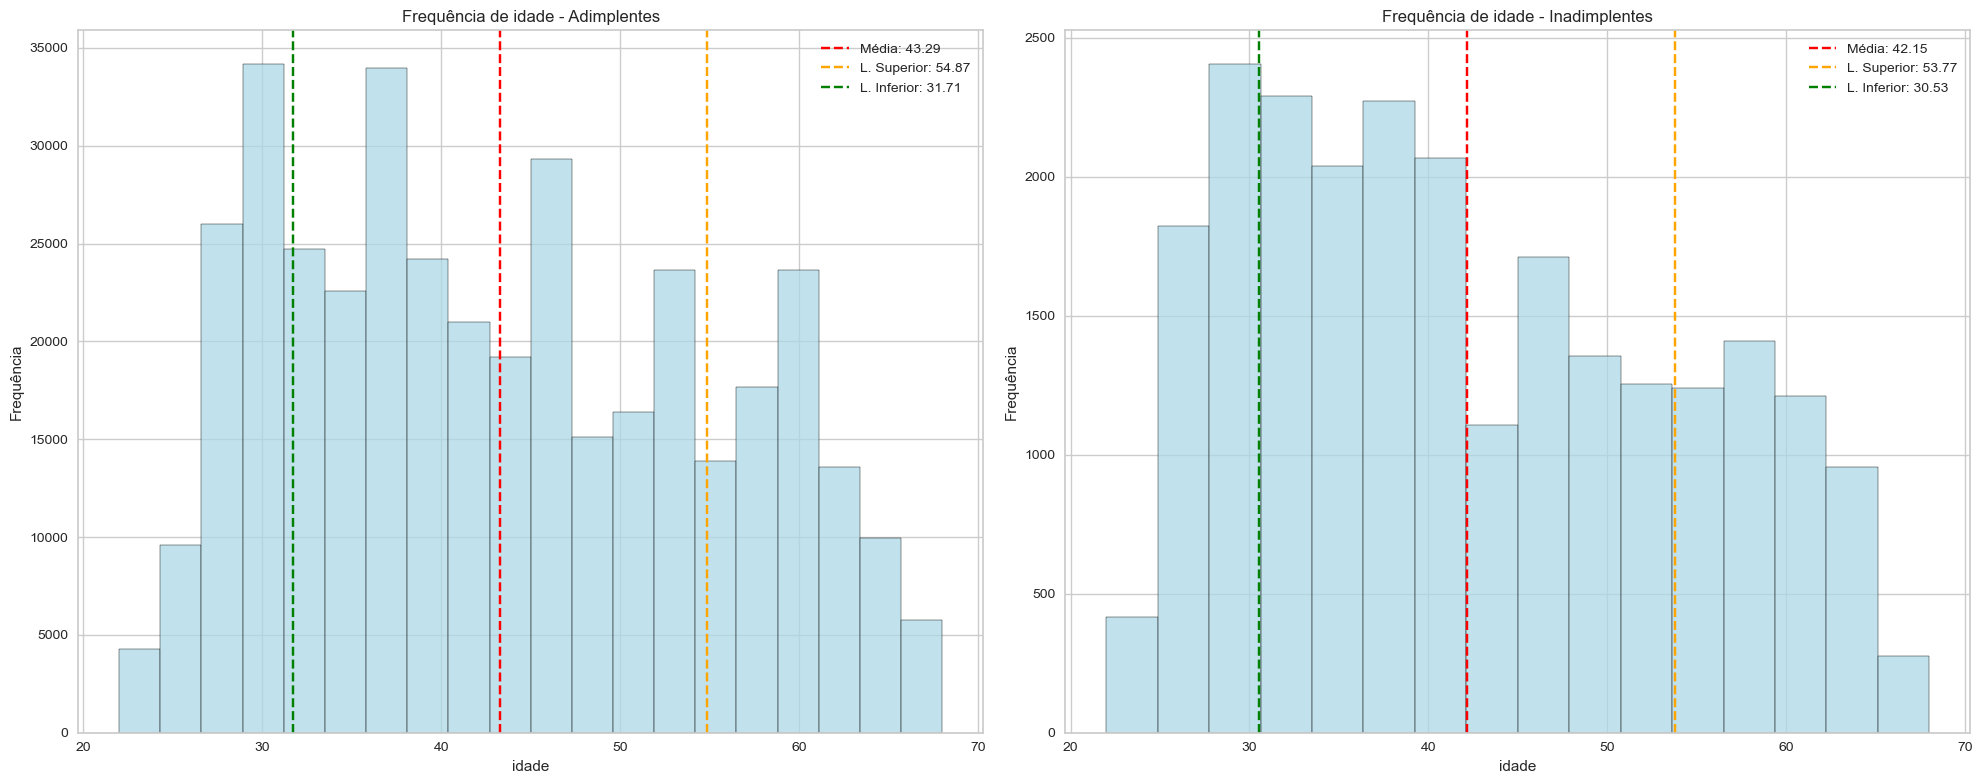

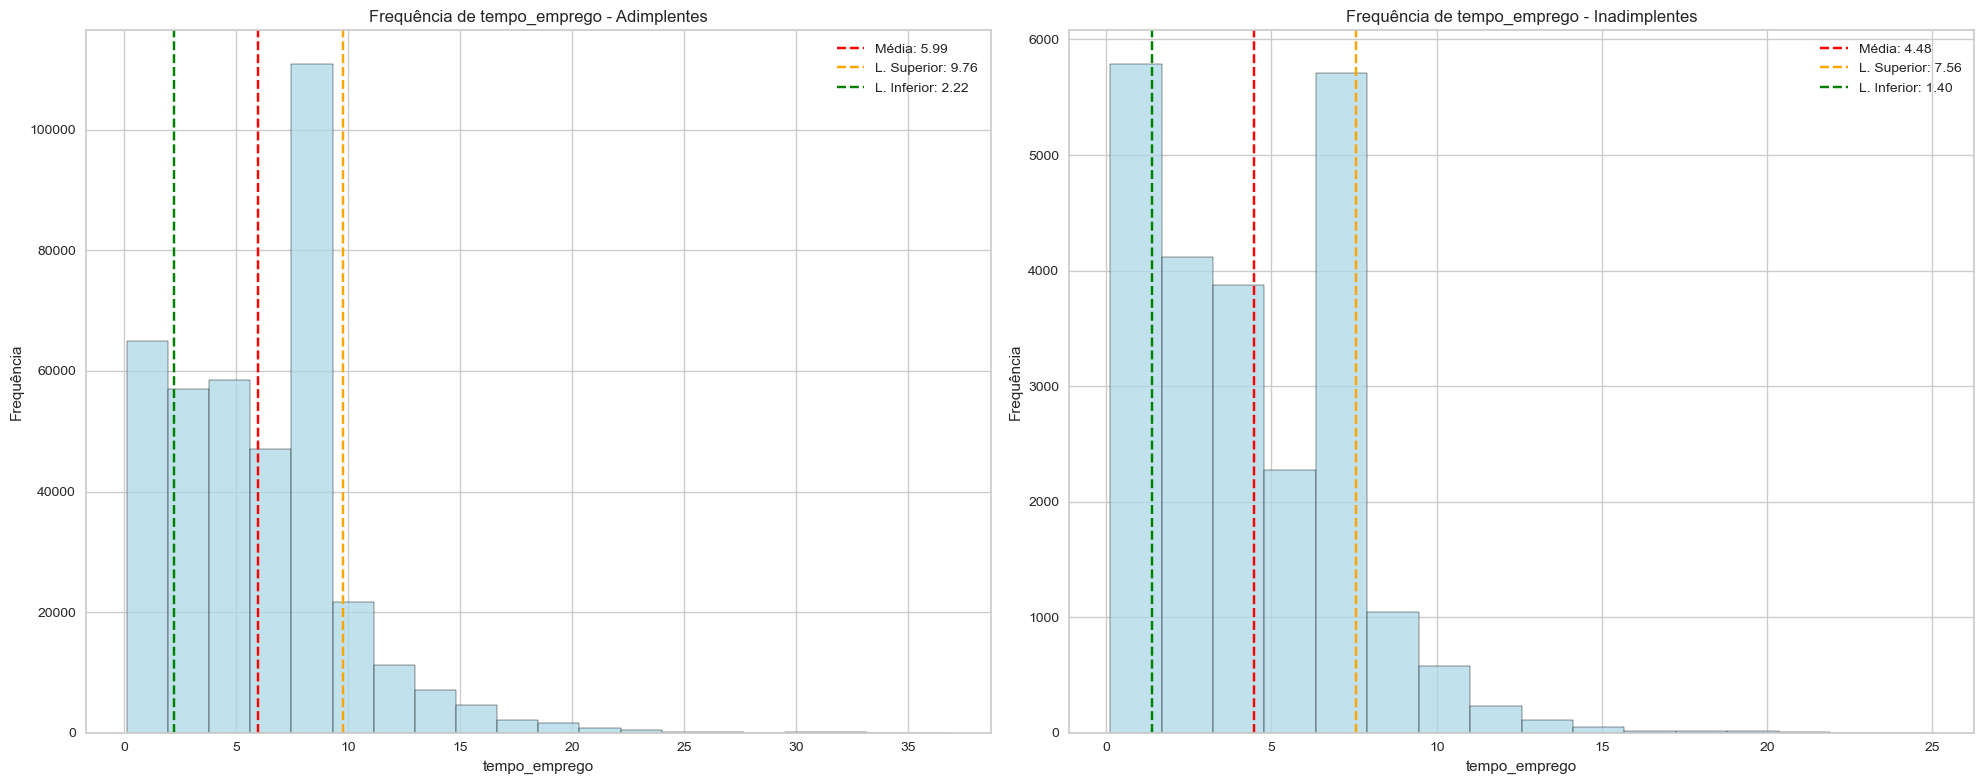

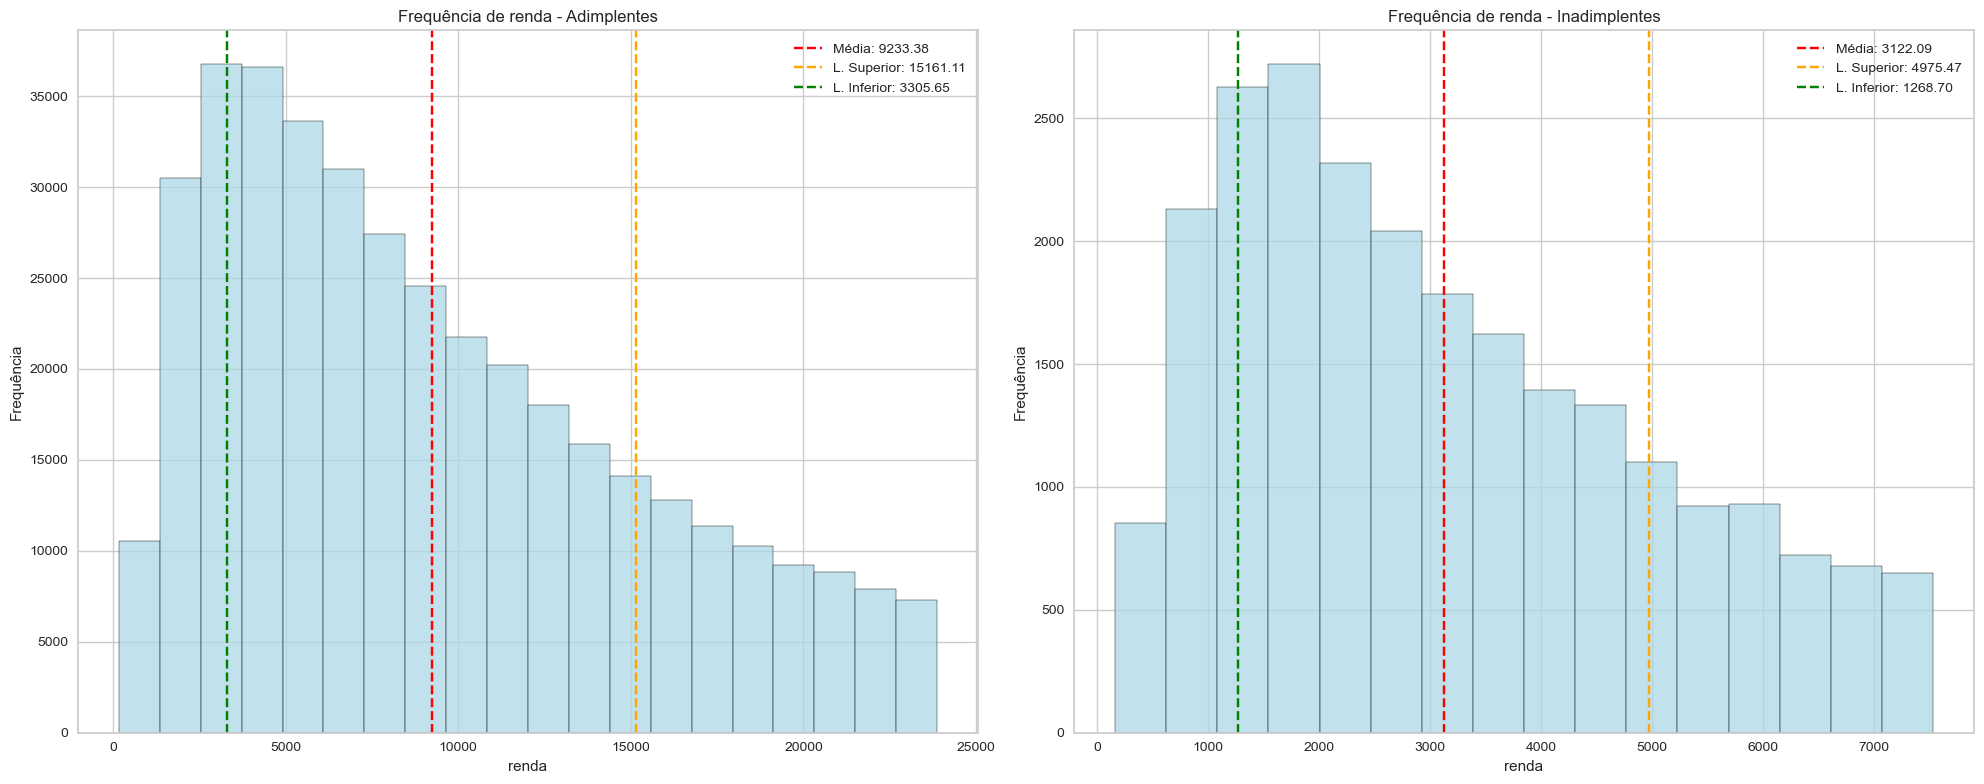

In [22]:
for var in quantitativas:
    
    # Criar figura e eixos para os subplots
    fig, axs = plt.subplots(1, 2, figsize=(20, 8))
    
    for i, dataframe in enumerate([df_quantitativa_bom, df_quantitativa_mau]):
        # Esse for percorre a lista dos dfs, onde i é o indice 0 e 1 (valores usados no axs)
        ###################################################################
        # Calcular o número total de observações
        N = dataframe.shape[0]
        # Calcular o número ideal de classes usando a Regra de Sturges
        k = 1 + np.log2(N)
        # Arredondar o resultado para o próximo inteiro
        k = int(np.ceil(k))
        ###################################################################
        #
        ###################################################################
        # Calcular média e desvio padrão para df_quantitativa_bom e mau
        media = dataframe[var].mean()
        desvio_padrao = dataframe[var].std()
        ###################################################################
        #
        ###################################################################
        # Plotar o histograma para df_quantitativa_bom
        sns.histplot(dataframe[var], bins=k, color='lightblue', edgecolor='black', ax=axs[i], kde=False)
        axs[i].axvline(media, color='red', linestyle='--', label=f'Média: {media:.2f}')
        axs[i].axvline(media + desvio_padrao, color='orange', linestyle='--', label=f'L. Superior: {media + desvio_padrao:.2f}')
        axs[i].axvline(media - desvio_padrao, color='green', linestyle='--', label=f'L. Inferior: {media - desvio_padrao:.2f}')
        axs[i].set_xlabel(f'{var}')
        axs[i].set_ylabel('Frequência')
        if i == 0: # Criado uma condicional para mostrar o titulo correto para cada gráfico
            axs[i].set_title(f'Frequência de {var} - Adimplentes')
        else:
            axs[i].set_title(f'Frequência de {var} - Inadimplentes')
        axs[i].legend()
        axs[i].grid(True)
    # Ajustar o layout
    plt.tight_layout()
    plt.show()

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

#### Para fazer essa análise vou precisar verificar a correlação entre as variáveis, para isso será necessário fazer alguns tratamentos para não ter um resultado com estimativa incorreta.

### Renda e seus outliers

#### Sabendo que a média geral é de 28614.22 e que os outliers ainda não foram tratados, preciso escolher uma porção dos dados que não vão impactar tanto em toda análise, como tem uma boa quantidade de dados para análisar, escolhi por deixar esses valores muito fora da curva de fora por enquanto, a questão é até qual parte selecionar.
<br>

#### Pensei em alterar os valores usando logaritimo ou uma normalização para deixar o mínimo de dados possiveis de fora da análise, porém existe outliers tão grandes que mesmo com essas técnicas vou precisar retiralos.

#### Abaixo foi tirado a média de várias porções dos dados para ter uma noção da diferença a medida que aumenta o quantil, levando em consideração que a diferença entre os quantis são de 25%, 15%, 5% e 4% da para ter uma noção do quanto os valores estão aumentando rapidamente mesmo com uma diferença de quantidade de dados menor.
<br>

#### Com intuito de fazer a análise com a maior quantidade de dados possíveis, será usado apenas até o quantil 90%, deixando excluso os 10% maiores rendas, mas esses valores podem retornar em uso no momento da modelagem.

In [23]:
# Calcular os quantis de renda
quantil_50 = df_modelar['renda'].quantile(0.50)
quantil_75 = df_modelar['renda'].quantile(0.75)
quantil_90 = df_modelar['renda'].quantile(0.90)
quantil_95 = df_modelar['renda'].quantile(0.95)
quantil_99 = df_modelar['renda'].quantile(0.99)

# Filtrar os dados de acordo com o quantil criado anteriormente
df_modelar_50 = df_modelar[df_modelar['renda'] <= quantil_50]
df_modelar_75 = df_modelar[df_modelar['renda'] <= quantil_75]
df_modelar_90 = df_modelar[df_modelar['renda'] <= quantil_90]
df_modelar_95 = df_modelar[df_modelar['renda'] <= quantil_95]
df_modelar_99 = df_modelar[df_modelar['renda'] <= quantil_99]

# Calcular a média de cada df filtrado
media_50 = df_modelar_50['renda'].mean()
media_75 = df_modelar_75['renda'].mean()
media_90 = df_modelar_90['renda'].mean()
media_95 = df_modelar_95['renda'].mean()
media_99 = df_modelar_99['renda'].mean()

print(f'Média 50: {media_50} \nMédia 75: {media_75} \nMédia 90: {media_90} \nMédia 95: {media_95} \nMédia 99: {media_99}')

Média 50: 5265.639632950793 
Média 75: 8700.748753945434 
Média 90: 12796.169071965218 
Média 95: 15705.815781145333 
Média 99: 21883.604292310065


#### Nesse conjunto de dados a renda vai ser transformada onde seu valor máximo é 1 e seu valor minimo é 0, essa técnica do Min-Max Scaling junto com o uso apenas das 90% menores valores vai ajudar a trabalhar nas comparações sem o impacto dos outliers.

In [24]:
# Calcule os valores mínimo e máximo da coluna 'renda'
min_renda = df_modelar_90['renda'].min()
max_renda = df_modelar_90['renda'].max()

# Aplique a fórmula de Min-Max Scaling para normalizar os valores
df_modelar_90['renda'] = (df_modelar_90['renda'] - min_renda) / (max_renda - min_renda)

In [25]:
# Looping que percorre todas colunas quantitativas e divide em 10 quantis
for coluna in quantitativas:
    df_modelar_90[coluna] = pd.qcut(df_modelar_90[coluna], q=10, labels=False, duplicates='drop')

#### Para análisar a relação entre as variáveis, foi usado a correlação de V de Cramér, foi escolhido esse método devido a quantidade de variáveis categóricas, tanto ordinais quanto nominais e a possibilidade de transformar as numéricas continuas em categóricas ordinais, como foi feito com as variáveis quantitativas no looping anterior. 
<br>

#### Esse método trabalha bem análisando variáveis categóricas ao construir tabelas de contingências (cross-tab) e com essa tabela compara a frequencia que duas variáveis ocorrem juntas, usa o qui-quadrado para o calculo da associação das variáveis e depois aplicado a fórmula do Vde Cramér, essa fórmula normaliza o calculo do qui-quadrado para que os valores fiquem entre 0 e 1, onde 0 é uma associação fraca e próximo de 1 uma associação forte.

In [26]:
# Converter variável booleana em inteira 0 e 1
df_modelar_90['mau'] = df_modelar_90['mau'].astype(int)
# Converte o tipo flutuante float em inteiro
df_modelar_90['qt_pessoas_residencia'] = df_modelar_90['qt_pessoas_residencia'].astype(int)

#### Fórmula V de Cramér

![Cramér's V](https://latex.codecogs.com/svg.latex?V%20%3D%20%5Csqrt%7B%5Cfrac%7B%5Cchi%5E2%20%7D%7Bn%20*%20%5Cmin%28k-1%2C%20r-1%29%7D%7D)

<br>

Onde:

- **V**: coeficiente de correlação de Cramér-V.
- **χ^2**: estatística qui-quadrado obtida a partir da tabela de contingência entre as duas variáveis categóricas.
- **n**: número total de observações.
- **k**: número de categorias na variável independente.
- **r**: número de categorias na variável dependente.

In [27]:
# Função para calcular o V de Cramer
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y) # Faz as duas crosstab uma de cada variável
    chi2 = chi2_contingency(confusion_matrix)[0] # Calcula o qui-quadrado dos crosstabs
    n = confusion_matrix.sum().sum() # Calcula o numero total de observações
    phi2 = chi2 / n # Calcula o qui-quadrado pelo número de observações
    r, k = confusion_matrix.shape # Numero de categorias das variáveis comparadas
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1)) # se o valor de phi2 for menor que zero, ele deixa em zero como limite
    '''Ajustando o número de categorias na variável x, levando em consideração o tamanho 
    da amostra. Isso é feito subtraindo um valor que é proporcional ao número total de 
    observações e ao número de categorias.'''
    rcorr = r - ((r-1)**2)/(n-1)
    '''Ajustando o número de categorias na variável y, 
    novamente levando em consideração o tamanho da amostra.'''
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1))) # Calcula o coeficiente de Cramér-V final

# Criando uma matriz vazia no tamanho que vai precisar
corr_matrix = pd.DataFrame(index=df_modelar_90.columns, columns=df_modelar_90.columns)

# Looping vai percorer todas variáveis duas vezes e comparar entre elas aplicando a função
# criada cramers_v e populando a matriz criada acima
for i in range(len(df_modelar_90.columns)):
    for j in range(len(df_modelar_90.columns)):
        if i != j:  # Verifica se as colunas são diferentes
            corr_matrix.iloc[i, j] = cramers_v(df_modelar_90[df_modelar_90.columns[i]], df_modelar_90[df_modelar_90.columns[j]])
        else:
            corr_matrix.iloc[i, j] = 0  # Define 0 quando as colunas são iguais
display(corr_matrix)

,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
sexo,0,0.37,0.06,0.12,0.21,0.02,0.17,0.09,0.22,0.18,0.15,0.07,0.02
posse_de_veiculo,0.37,0,0.02,0.13,0.17,0.11,0.17,0.05,0.19,0.14,0.18,0.03,0.00
posse_de_imovel,0.06,0.02,0,0.03,0.11,0.06,0.05,0.21,0.14,0.09,0.03,0.08,0.02
qtd_filhos,0.12,0.13,0.03,0,0.15,0.06,0.11,0.05,0.19,0.09,0.94,0.01,0.01
tipo_renda,0.21,0.17,0.11,0.15,0,0.10,0.11,0.07,0.40,0.42,0.14,0.05,0.02
educacao,0.02,0.11,0.06,0.06,0.10,0,0.05,0.06,0.14,0.08,0.05,0.03,0.01
estado_civil,0.17,0.17,0.05,0.11,0.11,0.05,0,0.05,0.16,0.10,0.45,0.02,0.01
tipo_residencia,0.09,0.05,0.21,0.05,0.07,0.06,0.05,0,0.10,0.08,0.06,0.02,0.01
idade,0.22,0.19,0.14,0.19,0.40,0.14,0.16,0.10,0,0.25,0.17,0.04,0.02
tempo_emprego,0.18,0.14,0.09,0.09,0.42,0.08,0.10,0.08,0.25,0,0.09,0.16,0.09


#### Mapa de calor dos resultados obtidos acima na matriz que tem os valores de comparações de cada variável entre sí, onde 1 é uma correlação perfeita e 0 tem nenhuma correlação.

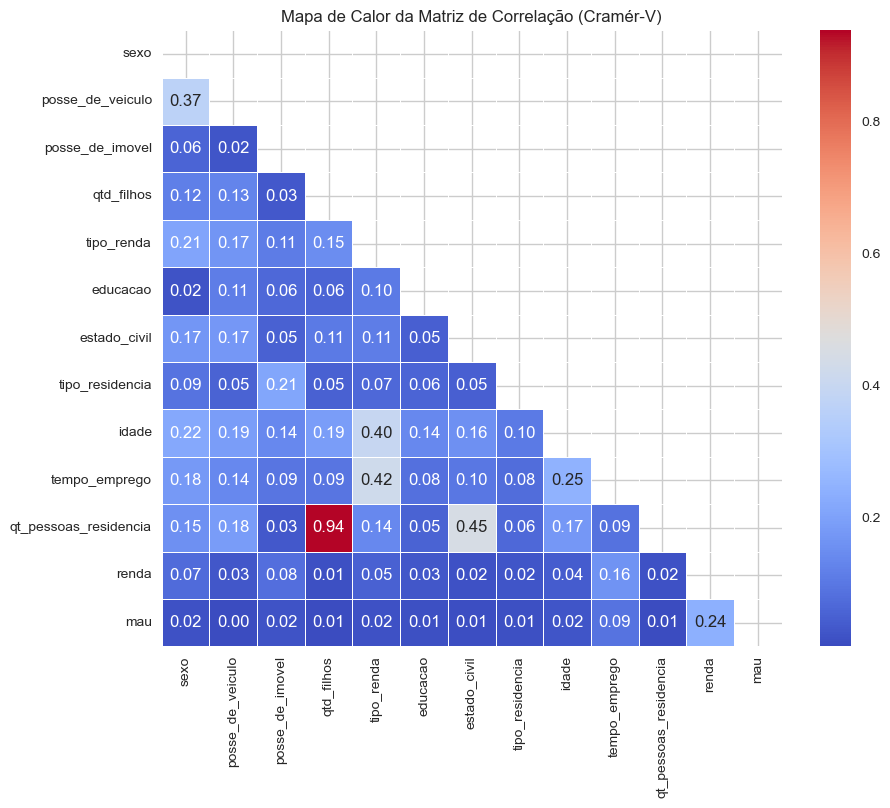

In [28]:
# Converter os valores da matriz para tipo numérico
corr_matrix = corr_matrix.astype(float)

# Máscara para excluir a metade repetida
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Plot do mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title('Mapa de Calor da Matriz de Correlação (Cramér-V)')
plt.show()

#### Deixando uma lista ordenada também para facilitar a verificação da associação.

In [29]:
# Transforma a correlação em uma série com o unstack e ordena com o sort_values, descrescente com o False
corr_matrix_ordenado = corr_matrix.unstack().sort_values(ascending=False)
# Remove linhas selecionadas (mantém a segunda, quarta, sexta, etc...)
corr_matrix_ordenado =corr_matrix_ordenado[1::2]
corr_matrix_ordenado.head(15)

qt_pessoas_residencia  qtd_filhos              0.94
estado_civil           qt_pessoas_residencia   0.45
tipo_renda             tempo_emprego           0.42
idade                  tipo_renda              0.40
sexo                   posse_de_veiculo        0.37
idade                  tempo_emprego           0.25
renda                  mau                     0.24
sexo                   idade                   0.22
posse_de_imovel        tipo_residencia         0.21
tipo_renda             sexo                    0.21
idade                  posse_de_veiculo        0.19
qtd_filhos             idade                   0.19
posse_de_veiculo       qt_pessoas_residencia   0.18
tempo_emprego          sexo                    0.18
idade                  qt_pessoas_residencia   0.17
dtype: float64

#### As comparações usando o V de Cramér tiveram alguns valores esperados como quantidade de filhos por quantidade de pessoas na residência, mas particularmente esperava uma associação maior entre 'renda' e a variável resposta 'mau'. Vou explorar mais afundo apenas as que tiveram valor de associação maior que 0.25.

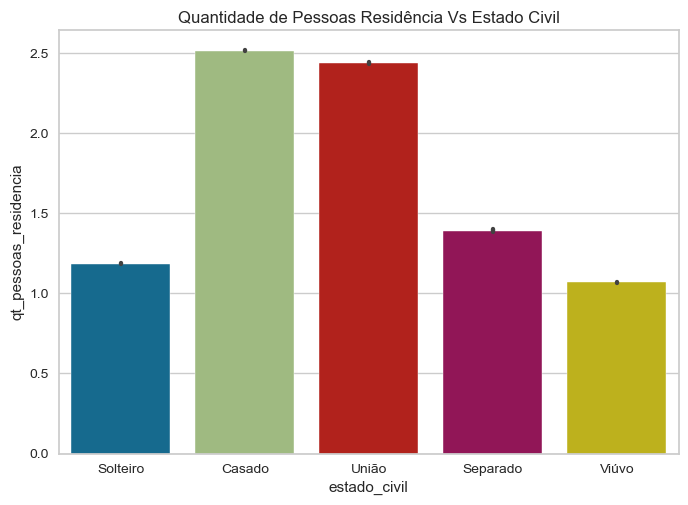

In [30]:
# Criando o gráfico de barras
sns.barplot(x='estado_civil', y='qt_pessoas_residencia', data=df_modelar_90)
# Adicionando título ao gráfico
plt.title('Quantidade de Pessoas Residência Vs Estado Civil')
# Exibindo o gráfico
plt.show()

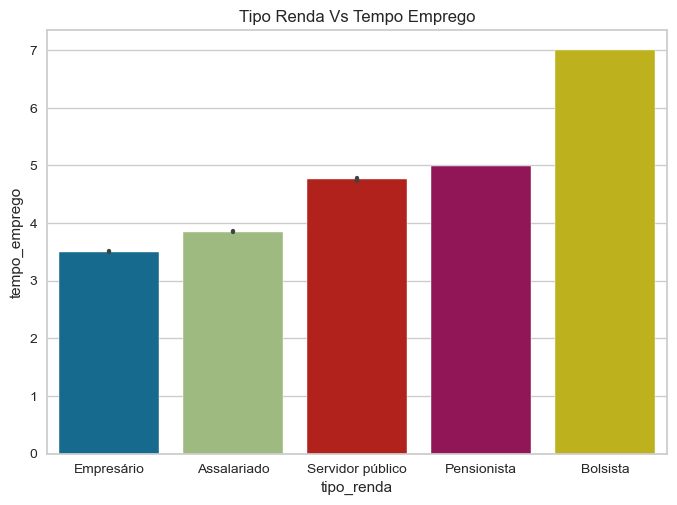

In [31]:
# Criando o gráfico de barras
sns.barplot(x='tipo_renda', y='tempo_emprego', data=df_modelar_90)
# Adicionando título ao gráfico
plt.title('Tipo Renda Vs Tempo Emprego')
# Exibindo o gráfico
plt.show()

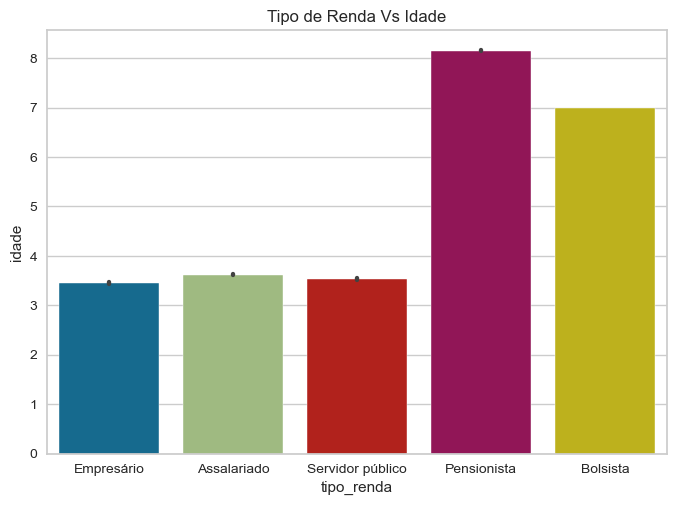

In [32]:
# Criando o gráfico de barras
sns.barplot(x='tipo_renda', y='idade', data=df_modelar_90)
# Adicionando título ao gráfico
plt.title('Tipo de Renda Vs Idade')
# Exibindo o gráfico
plt.show()

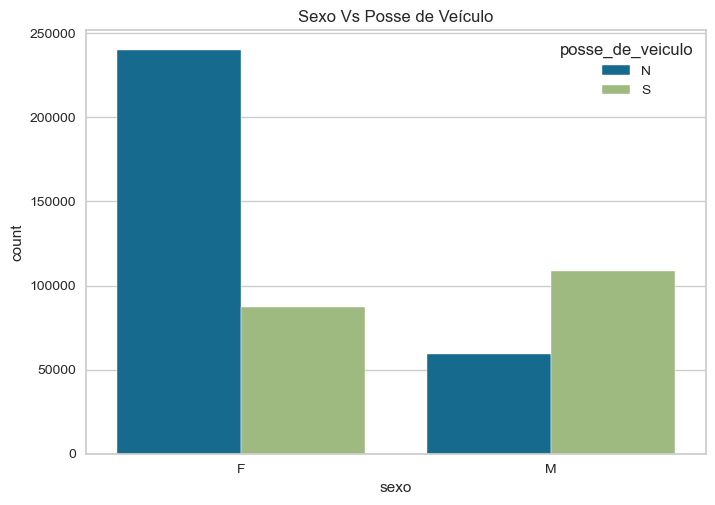

In [33]:
# Criando o gráfico de contagem
sns.countplot(x='sexo', hue='posse_de_veiculo', data=df_modelar_90)

# Adicionando título ao gráfico
plt.title('Sexo Vs Posse de Veículo')

# Exibindo o gráfico
plt.show()

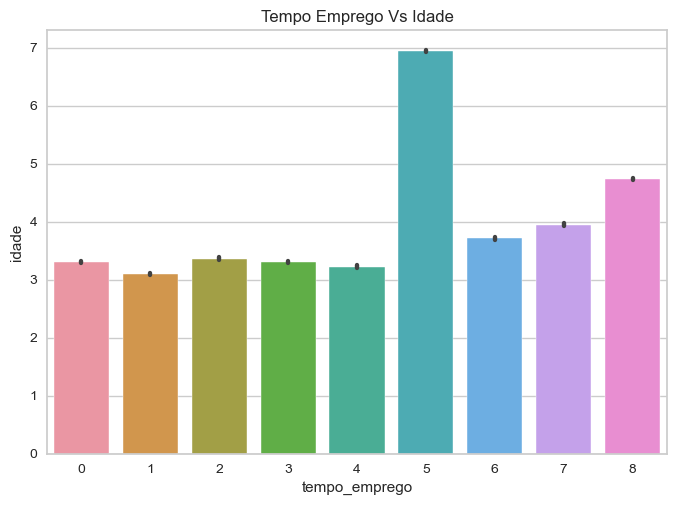

In [34]:
# Criando o gráfico de barras
sns.barplot(x='tempo_emprego', y='idade', data=df_modelar_90)
# Adicionando título ao gráfico
plt.title('Tempo Emprego Vs Idade')
# Exibindo o gráfico
plt.show()

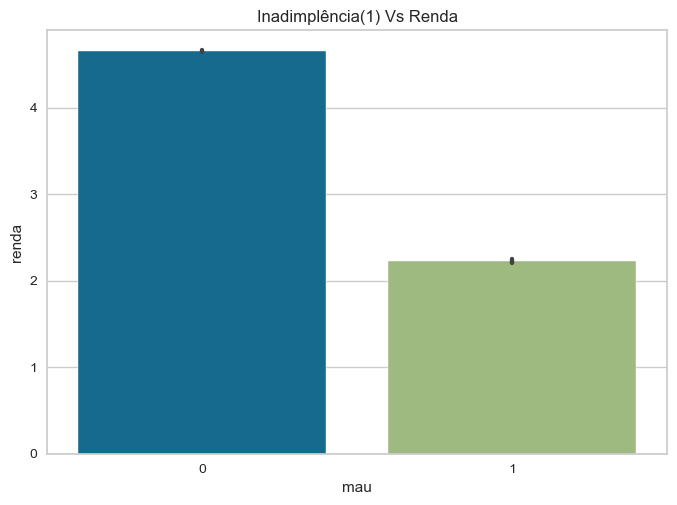

In [35]:
# Criando o gráfico de barras
ax = sns.barplot(x='mau', y='renda', data=df_modelar_90)

# Adicionando título ao gráfico
plt.title('Inadimplência(1) Vs Renda')

# Exibindo o gráfico
plt.show()

### Calculando o Information Value

#### O Information Value é usado para avaliar a importância das variáveis explicativas dada uma determinada variável resposta ('mau'), seus valores chegam a ser similares ao que foi visto no calculo do V de Cramér voltado para a variável resposta. Para seu calculo as categorias não podem estar zeradas e precisam estar categorizados.

#### Como temos um zero estrutural em qt_pessoas_residencia, primeiro será necessário arrumar isso para não dar divisão por zero, como a quantidade de pessoas residência de 6 para cima tem uma amostra muito pequena e tem um perfil similar, vou juntar esses valores em uma única categoria.

In [36]:
df_modelar_90['qt_pessoas_residencia'].value_counts()

2     265965
1      89168
3      88440
4      44899
5       5654
6        710
9         72
15        65
7         30
Name: qt_pessoas_residencia, dtype: int64

In [37]:
# Substituindo os valores 6, 9, 15 e 7 por um valor 6+
df_modelar_90['qt_pessoas_residencia'].replace({6: '6+', 9: '6+', 15: '6+', 7: '6+'}, inplace=True)
df_modelar_90['qt_pessoas_residencia'].value_counts()

2     265965
1      89168
3      88440
4      44899
5       5654
6+       877
Name: qt_pessoas_residencia, dtype: int64

In [38]:
# Criando dois DFs para comparar proporções e calcular o IV
df_inadimplente = df_modelar_90[df_modelar_90['mau']==1]
df_adimplente = df_modelar_90[df_modelar_90['mau']==0]
# Removendo a variável resposta mau para o calculo do IV não iterar sobre essa coluna
df_modelar_90 = df_modelar_90.drop(columns=['mau'])

In [39]:
# Dicionário para guardar os valores de IV de cada coluna
dic_IV = {}

for coluna in df_modelar_90.columns:
    # Salvando a quantidade de valores de cada categoria da coluna
    contagem_categorias_1 = df_inadimplente[coluna].value_counts()
    contagem_categorias_0 = df_adimplente[coluna].value_counts()
    # Reindexar contagem_categorias_1 com base nos índices de contagem_categorias_0 para ficarem iguais
    contagem_categorias_1 = contagem_categorias_1.reindex(contagem_categorias_0.index, fill_value=0)
    
    # Criando um DataFrame combinando os dois panda series acima
    # O passo para ordenar com base em um dos indices anteriormente é importante agora
    # para que a ordem das categorias sejam as mesmas
    df_table_stats = pd.DataFrame({coluna: contagem_categorias_0.index,
                   '0': contagem_categorias_0.values,
                   '1': contagem_categorias_1.values})
    
    # Criando  COLUNA total, que é  soma da coluna 0 e 1
    df_table_stats['total'] = df_table_stats['0'] + df_table_stats['1']

    # Calcular o total para as colunas '0', '1' e 'total' para incluir na 
    # criação da LINHA total
    total_0 = df_table_stats['0'].sum()
    total_1 = df_table_stats['1'].sum()
    total = df_table_stats['total'].sum()
    # Usado o .loc para criar uma LINHA ao invés de uma coluna
    df_table_stats.loc['total'] = ['Total', total_0, total_1, total]
    
    # Criando a coluna pct_0, que é a porcentagem da coluna 0 pelo seu total
    df_table_stats['pct_0'] = df_table_stats['0'] / df_table_stats.loc['total', '0']

    # Criando a coluna pct_1, que é a porcentagem da coluna 1 pelo seu total
    df_table_stats['pct_1'] = df_table_stats['1'] / df_table_stats.loc['total', '1']

    # Criando a coluna razão de chance, que é a porcentagem do evento dividido pela porcentagem de não evento
    df_table_stats['rc'] = df_table_stats['pct_1'] / df_table_stats['pct_0']

    # Criando a coluna weight of evidence, que é o logaritimo da divisão das porcentagens de evento e não evento
    df_table_stats['woe'] = np.log(df_table_stats['rc'])
    
    # Calculando o information value parcial de cada categoria
    df_table_stats['iv_parcial'] = df_table_stats['woe'] * (df_table_stats['pct_1'] - df_table_stats['pct_0'])
    
    # Mostrando todo o calculo para ter uma noção melhor
    print(df_table_stats)
    print('\n\n\n')
    
    # Adicionando coluna(chave) e valor do IV no dicionário dic_IV
    dic_IV[coluna] = df_table_stats['iv_parcial'].sum()


        sexo       0      1   total  pct_0  pct_1   rc   woe  iv_parcial
0          F  304903  21906  326809   0.66   0.69 1.05  0.05        0.00
1          M  158532   9662  168194   0.34   0.31 0.89 -0.11        0.00
total  Total  463435  31568  495003   1.00   1.00 1.00  0.00        0.00




      posse_de_veiculo       0      1   total  pct_0  pct_1   rc   woe  \
0                    N  279913  19350  299263   0.60   0.61 1.01  0.01   
1                    S  183522  12218  195740   0.40   0.39 0.98 -0.02   
total            Total  463435  31568  495003   1.00   1.00 1.00  0.00   

       iv_parcial  
0            0.00  
1            0.00  
total        0.00  




      posse_de_imovel       0      1   total  pct_0  pct_1   rc   woe  \
0                   S  310359  19782  330141   0.67   0.63 0.94 -0.07   
1                   N  153076  11786  164862   0.33   0.37 1.13  0.12   
total           Total  463435  31568  495003   1.00   1.00 1.00  0.00   

       iv_parcial  
0         

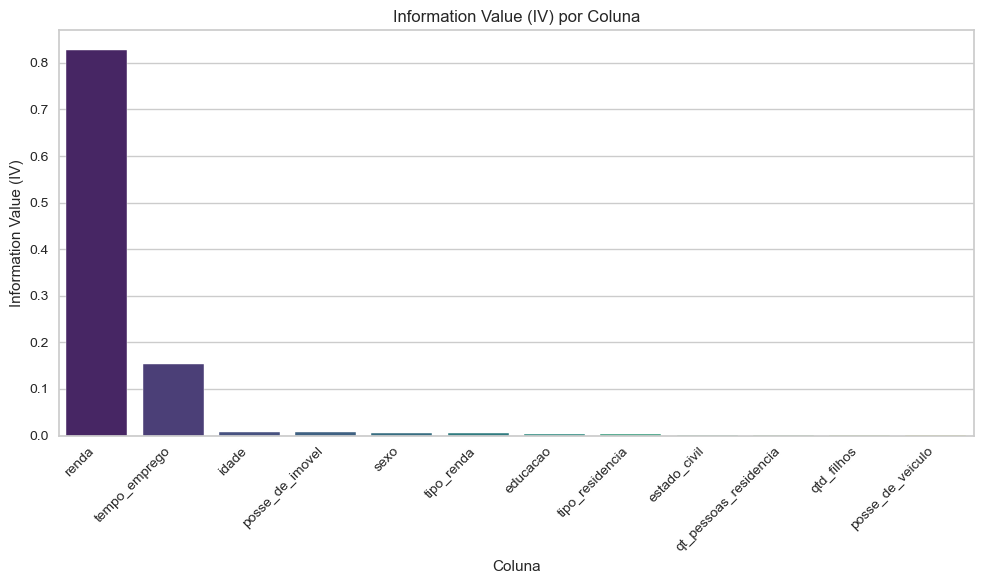

In [40]:
dic_IV_ordenado = {}

# O i itera sobre as chaves do dicionário, mas o get retorna seus valores associados
# Deixando na forma decrescente
for i in sorted(dic_IV, key = dic_IV.get, reverse=True):
    dic_IV_ordenado[i] = dic_IV[i]
dic_IV_ordenado

# Dimensões
plt.figure(figsize=(10, 6))

# Tipo barplot, usando as chaves no X e os valores no Y do dicionário dic_IV criado no looping anterior
sns.barplot(x=list(dic_IV_ordenado.keys()), y=list(dic_IV_ordenado.values()), palette='viridis')
plt.title('Information Value (IV) por Coluna')
plt.xlabel('Coluna')
plt.ylabel('Information Value (IV)')
plt.xticks(rotation=45, ha='right')  # Rotacionar os rótulos do eixo x para melhor visualização
plt.tight_layout()
plt.show()

#### Tabela de interpretação do Information Value

| Intervalo de IV     | Interpretação                                      |
|----------------------|----------------------------------------------------|
| IV < 0.02            | A variável tem uma capacidade de previsão fraca.  |
| 0.02 <= IV < 0.1    | A variável tem uma capacidade de previsão razoável. |
| 0.1 <= IV < 0.3     | A variável tem uma capacidade de previsão forte.   |
| IV >= 0.3           | A variável tem uma capacidade de previsão muito forte. |

#### Analisando as tabelas acima, fica mais fácil de entender quais variáveis estão colaborando na previsão da inadimplencia, nesse caso está bem dificil pois a renda como esperado é altamente relacionada, o tempo emprego tem uma capacidade forte, mas as variáveis restantes ajudam muito pouco pois a diferença entre as proporções de adimplentes e inadimplentes são minimas em cada caracteristica analisada anteriormente.
<br>

#### Os valores de associação obtidos com o V de Cramér com a variável resposta também ajudam a verificar quais categorias melhor explicam a adimplencia.

In [41]:
dic_IV_ordenado

{'renda': 0.8281582491879957,
 'tempo_emprego': 0.15280089158806848,
 'idade': 0.008397634078665318,
 'posse_de_imovel': 0.008132784517003017,
 'sexo': 0.005924609299295784,
 'tipo_renda': 0.005260965922904658,
 'educacao': 0.002621737261748098,
 'tipo_residencia': 0.002429765172562442,
 'estado_civil': 0.0017408164023444378,
 'qt_pessoas_residencia': 0.0009756867563937204,
 'qtd_filhos': 0.0009022823868823067,
 'posse_de_veiculo': 0.00033747035964501373}

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

## Missing

#### Os valores missing já foram tratados anteriormente para não comprometer a análise, sendo preenchido pela média na tentativa de não impactar, não alterar a variabilidade dos dados.

## Outliers

In [42]:
# Criando uma cópia para compara antes e depois dos outliers
# Vou permanececr com o df_modelar ao invés de criar novas versões, para evitar ficar com varias versões
df_modelar_com_outlier = df_modelar.copy()

### Z-Score

#### O Z-score, também conhecido como escore padrão, é uma medida estatística que indica quantos desvios padrão um ponto de dados está acima ou abaixo da média de um conjunto de dados.

#### No código abaixo, está sendo filtrado os dados que estão 3 desvios padrão acima do limite (inferior ou superior).

In [43]:
df_modelar_z = df_modelar.copy()

# Calculando o Z-score
df_modelar_z['z_score'] = stats.zscore(df_modelar_z['renda'])

# Identificando outliers
outliers_z = df_modelar_z[abs(df_modelar_z['z_score']) > 3]
outliers_z

,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,z_score
622,F,N,S,0,Assalariado,Médio,Casado,Casa,60,39.82,2.00,537260.45,False,5.62
1085,F,S,S,0,Servidor público,Superior completo,Solteiro,Casa,60,41.20,1.00,385062.48,False,3.94
1973,F,S,S,0,Servidor público,Superior completo,Solteiro,Casa,60,41.20,1.00,340223.94,False,3.44
2809,F,S,S,0,Assalariado,Médio,Casado,Casa,54,34.50,2.00,332236.70,False,3.35
3247,F,N,S,0,Assalariado,Superior completo,Solteiro,Casa,60,29.04,1.00,647076.34,False,6.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
548571,F,N,S,0,Empresário,Médio,Casado,Casa,47,26.19,2.00,343836.61,False,3.48
548825,F,N,S,0,Empresário,Médio,Viúvo,Casa,55,32.62,1.00,307921.13,False,3.08
549304,F,S,S,0,Servidor público,Superior completo,Solteiro,Casa,60,41.20,1.00,456139.53,False,4.72
549593,F,N,S,0,Empresário,Médio,Casado,Casa,62,40.48,2.00,992983.16,False,10.65


In [44]:
# Removendo os valores classificados pelo Z-Score
df_modelar_z = df_modelar_z.drop(outliers_z.index)

#### Após remover alguns outliers, o gráfico ainda possui muitos valores passando do seu limite, porém os quartis não estão esmagados. O valor da quantidade de desvios padrão pode ser alterados, mas prefiro explorar um pouco mais esses impactos.

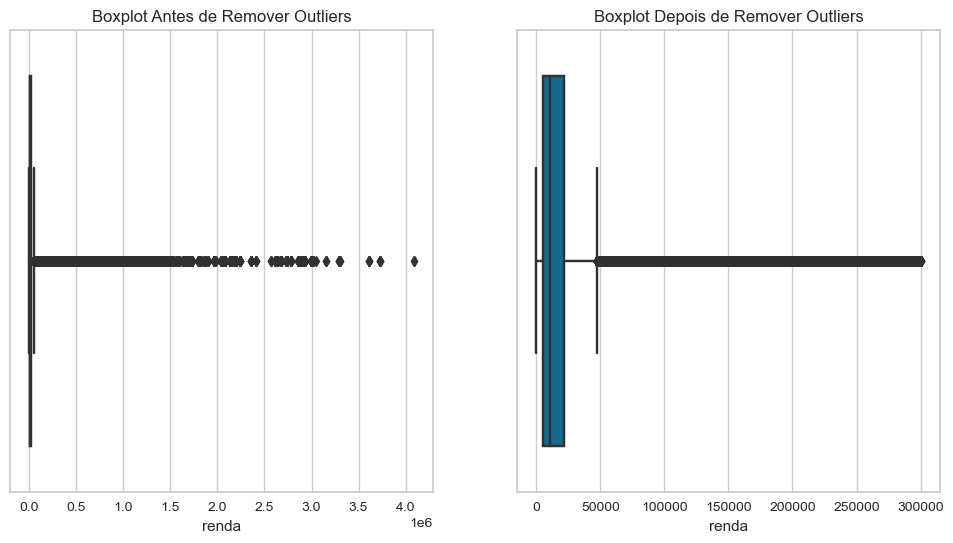

In [45]:
# Boxplots antes e depois de remover outliers
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(data=df_modelar_com_outlier, x='renda')
plt.title('Boxplot Antes de Remover Outliers')

plt.subplot(1, 2, 2)
sns.boxplot(data=df_modelar_z, x='renda')
plt.title('Boxplot Depois de Remover Outliers')

plt.show()

### Distribuição da renda pelos percentis.
#### Para ter uma melhor noção do quão impactante está sendo os outliers e em qual percentil estão agrupados, dividi o conjunto de dados de 1% em 1%, para poder ver a curvatura (aumento da renda) e distância entre os percentis (diferença de valores entre os percentis).
<br>

#### Então no looping abaixo e no gráfico é mostrado a porcentagem de dados (1% em  1%) Vs a porcentagem de renda acumulada. Sendo assim é possível perceber que do percentil 98 para o 99 tem um incrivel aumento de quase 10% e do percentil 99 para o total fica um gap de praticamente 25%, o que ainda mais incrível.

In [46]:
perc = 0.01
dic_perc = {}
total_renda = df_modelar['renda'].sum()

while perc <= 1.0:
    # Calcular o quantil de renda
    quantil = df_modelar['renda'].quantile(perc)
    # Calcular a proporção da soma parcial em relação ao total da renda
    soma_parcial = df_modelar[df_modelar['renda'] <= quantil]['renda'].sum()
    dic_perc[round(perc, 2)] = soma_parcial / total_renda
    # Incrementar perc com precisão
    perc += 0.01

dic_perc

{0.01: 0.00023498529826874293,
 0.02: 0.0006008792276166025,
 0.03: 0.001054454357277483,
 0.04: 0.0015829166707051914,
 0.05: 0.0021809425147112298,
 0.06: 0.002839134471338497,
 0.07: 0.0035569749358886024,
 0.08: 0.004335050922288338,
 0.09: 0.005170709884770936,
 0.1: 0.006060746698524655,
 0.11: 0.007005438478154446,
 0.12: 0.008004777737871692,
 0.13: 0.009062012734253815,
 0.14: 0.010172193990439943,
 0.15: 0.011338571729607604,
 0.16: 0.012558447010112966,
 0.17: 0.013830782178129341,
 0.18: 0.015159491984669343,
 0.19: 0.016544056561697083,
 0.2: 0.017985632318362574,
 0.21: 0.019482186497376125,
 0.22: 0.02103411714431666,
 0.23: 0.02264393067099593,
 0.24: 0.02431038905404207,
 0.25: 0.026038383119247912,
 0.26: 0.027826997450167767,
 0.27: 0.02967665458941888,
 0.28: 0.031590719790717016,
 0.29: 0.033567233426338085,
 0.3: 0.03560867586192109,
 0.31: 0.037712609603709195,
 0.32: 0.039884633119939894,
 0.33: 0.04212249650826646,
 0.34: 0.044430383461637475,
 0.35: 0.04680682

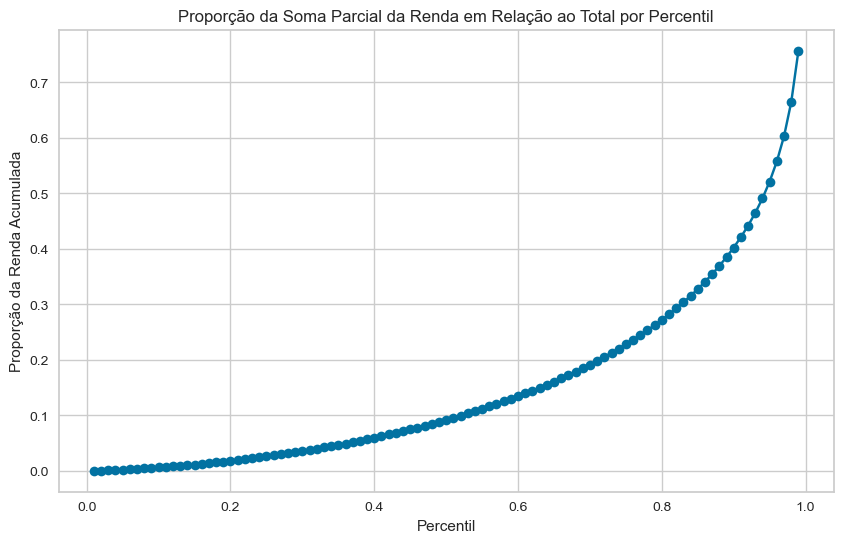

In [47]:
plt.figure(figsize=(10, 6))
plt.plot(list(dic_perc.keys()), list(dic_perc.values()), marker='o')
plt.title('Proporção da Soma Parcial da Renda em Relação ao Total por Percentil')
plt.xlabel('Percentil')
plt.ylabel('Proporção da Renda Acumulada')
plt.grid(True)
plt.show()

#### Apesar do Z-Score ter feito uma boa divisão dos dados, ainda não fiquei satisfeito e queria ter uma noção melhor do quão impactante é cada outlier. Sendo assim construi um DataFrame que salva o indice, a diferença da média geral e uma nova média removendo o outlier e um valor normalizado dessa diferença usando a escala MinMax.
<br>

#### Dessa forma, os valores 1 fazem a maior diferença na média e 0 quase nenhuma diferença na média, ou seja, os outliers a serem removidos vão fazer uma grande diferença na média e essa diferença vai poder ser medida e depois pode ser feito um gráfico para entender visualmente onde está essa diferença, para escolher um corte.

In [48]:
# Calcula a média geral da coluna "renda"
media_geral = df_modelar['renda'].mean()
n = len(df_modelar)
# Lista para armazenar as diferenças
diferencas = []
# Itera sobre cada índice e valor na coluna "renda"
for i, valor in df_modelar['renda'].iteritems():
    # Calcula a média excluindo o valor atual
    media_sem_valor = (n * media_geral - valor) / (n - 1)
    # Calcula a diferença entre a média sem o valor e a média geral
    diferenca = media_geral - media_sem_valor
    # Armazena a diferença e o índice correspondente
    diferencas.append((i, diferenca))
# Converte a lista de diferenças para um DataFrame
df_diferencas = pd.DataFrame(diferencas, columns=['indice', 'diferenca'])
# Ordena o DataFrame pelas diferenças em ordem decrescente para ranquear os outliers
df_diferencas = df_diferencas.sort_values(by='diferenca', ascending=False)

# Calcule os valores mínimo e máximo da coluna 'diferenca'
min_diferenca = df_diferencas['diferenca'].min()
max_diferenca = df_diferencas['diferenca'].max()
df_diferencas['diferenca_normalizada'] = (df_diferencas['diferenca'] - min_diferenca) / (max_diferenca - min_diferenca)
df_diferencas

,indice,diferenca,diferenca_normalizada
317856,317856,7.37,1.00
348460,348460,7.37,1.00
264908,264908,6.73,0.91
373702,373702,6.73,0.91
399456,399456,6.73,0.91
...,...,...,...
41926,41926,-0.05,0.00
26328,26328,-0.05,0.00
17934,17934,-0.05,0.00
17795,17795,-0.05,0.00


#### Como explicado anteriormente, este gráfico tem a intenção de entender onde os maiores outliers se concentram. Como o DataFrame tem muitos dados, existe uma quantidade significante de valores extremamente altos, a dificuldade é entender se são altos o suficientes para serem muito fora da curva ou não.
<br>

#### No gráfico abaixo que representa as diferenças das médias com a remoção de cada outlier, é possível observar que mais ou menos por volta do 0.05 ao 0.10 tem uma curva, que é onde os outliers realmente estão pesando muito e fica dificil de mante-los mesmo fazendo uma transformação dos dados.

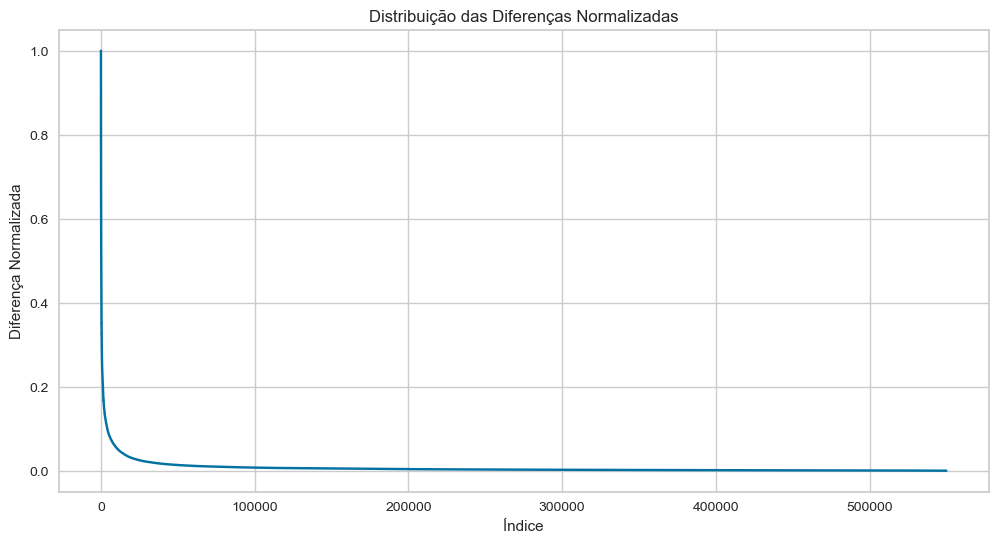

In [49]:
plt.figure(figsize=(12, 6))
plt.plot(df_diferencas['diferenca_normalizada'].values)
plt.title('Distribuição das Diferenças Normalizadas')
plt.xlabel('Índice')
plt.ylabel('Diferença Normalizada')
plt.show()

#### Os outliers são importântes para analise, eles podem explicar fenomenos imprevisiveis que podem acontecer, porém esse conjunto de dados está com excesso desses valores além de ser valores muito discrepantes. Ao verificar o corte visto no gráfico acima, deixando como 0.08, 5884 linhas foram consideradas outliers, o que é cerca de 1% do meu total de dados e ainda é uma quantidade menor do que a indicada pelo Z-Score, apesar de ter tido um resultado bem similar.

In [50]:
total_outliers = df_diferencas[df_diferencas['diferenca_normalizada'] > 0.08].shape[0]

print(f'Total de elementos identificados muito fora da curva: {total_outliers}')
print(f'Proporção de outliers no total de dados: {total_outliers/df_modelar.shape[0]}')

Total de elementos identificados muito fora da curva: 5884
Proporção de outliers no total de dados: 0.010698181818181818


#### Remoção dos Outliers

In [51]:
# Identificar os índices dos outliers
outliers_indices = df_diferencas[df_diferencas['diferenca_normalizada'] > 0.08]['indice']
# Passando os indices a serem dropados
df_modelar = df_modelar.drop(outliers_indices)

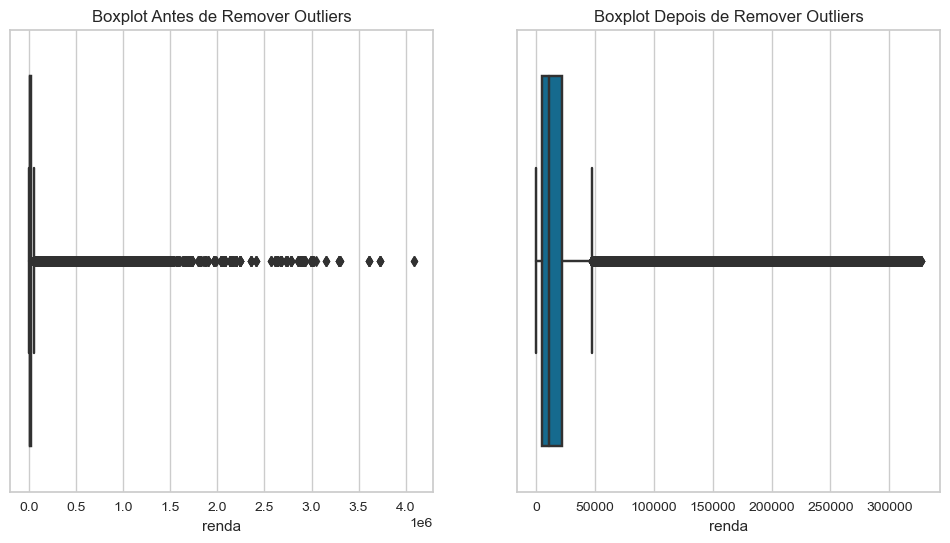

In [52]:
# Boxplots antes e depois de remover outliers
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(data=df_modelar_com_outlier, x='renda')
plt.title('Boxplot Antes de Remover Outliers')

plt.subplot(1, 2, 2)
sns.boxplot(data=df_modelar, x='renda')
plt.title('Boxplot Depois de Remover Outliers')

plt.show()

#### Como os resultados do Z-Score e de minha analise usando o peso que cada variável tem na média ao ser removido tem resultados similares, ambos podem ser usados para o tratamento.  Consegui explorar melhor a caracteristicas e o quão fora dos limites com a minha exploração, então preferi deixar o DataFrame(df_modelar) com o tratamento feito dessa maneira.

### Zero Estrutural

#### Da mesma forma vista no calculo do InformationValue e o df_modelar_90, aqui será feito essa alteração para o df_modelar

In [53]:
# Converte o tipo flutuante float em inteiro
df_modelar['qt_pessoas_residencia'] = df_modelar['qt_pessoas_residencia'].astype(int)

# Substituindo os valores 6, 9, 15 e 7 por um valor 6+
df_modelar['qt_pessoas_residencia'].replace({6: '6+', 9: '6+', 15: '6+', 7: '6+'}, inplace=True)
df_modelar['qt_pessoas_residencia'].value_counts()

2     295596
1      97692
3      94951
4      48779
5       6111
6+       987
Name: qt_pessoas_residencia, dtype: int64

### Agrupamentos

#### Levando em consideração a quantidade de informação que cada variável trás, eu removeria a maioria, mas foi fazer um comparativo entre deixar as variáveis em geral e apenas as variáveis que realmente explicar a variável resposta "mau".

#### Os agrupamentos abaixo foram feitos devido a baixa amostragem ou capacidade de diferenciar das demais categorias, o estado civil não precisou ser alterado e a quantidade de pessoas residência já teve seu processo feito devido ao zero estrutural e a necessidade de calcular o IV.

In [54]:
# Substituindo os valores 5, 7 e 14 por um valor 5+
df_modelar['qtd_filhos'].replace({5: '5+', 7: '5+', 14: '5+'}, inplace=True)
df_modelar['qtd_filhos'].value_counts()

0     374274
1     111599
2      50848
3       6408
4        782
5+       205
Name: qtd_filhos, dtype: int64

In [55]:
# Incluindo os valores de Bolsista em Assalariado 
df_modelar['tipo_renda'].replace({'Bolsista': 'Assalariado'}, inplace=True)
df_modelar['tipo_renda'].value_counts()

Assalariado         279620
Empresário          125497
Pensionista          92721
Servidor público     46278
Name: tipo_renda, dtype: int64

In [56]:
# Agrupando fundamental e médio como "Básico" e os demais como "Avançado"
df_modelar['educacao'].replace({'Fundamental': 'Básico', 'Médio': 'Básico', 
                                'Superior incompleto': 'Avançado', 
                                'Superior completo': 'Avançado',
                               'Pós graduação': 'Avançado'}, inplace=True)
df_modelar['educacao'].value_counts()

Básico      374089
Avançado    170027
Name: educacao, dtype: int64

In [57]:
# Juntando Estúdio, Comumnitário e Governamental em Outros
df_modelar['tipo_residencia'].replace({'Estúdio': 'Outros', 'Comunitário': 'Outros', 
                                       'Governamental': 'Outros'}, inplace=True)
df_modelar['tipo_residencia'].value_counts()

Casa           488917
Com os pais     24441
Outros          23246
Aluguel          7512
Name: tipo_residencia, dtype: int64

### Regressão Logística

#### BALANCEAR

In [58]:
proporcao_mau_True = df_modelar['mau'].value_counts(normalize=True)
proporcao_mau_True

False   0.94
True    0.06
Name: mau, dtype: float64

In [59]:
df_modelar_1 = df_modelar[df_modelar['mau']==1]
n = df_modelar_1.shape[0]*3 # Calculando 75% dos valores
df_modelar_0 = df_modelar[df_modelar['mau'] == 0].sample(n=n)
df_modelar = pd.concat([df_modelar_1, df_modelar_0])

# Calculando nova propoprção e esperando um valor de 75% e 25%
proporcao_mau_True = df_modelar['mau'].value_counts(normalize=True)
proporcao_mau_True

False   0.75
True    0.25
Name: mau, dtype: float64

#### ONE-HOT ENCODING
<br>

#### A Regressão Logística é um modelo linear que funciona melhor com variáveis numéricas e não pode lidar diretamente com variáveis categóricas com mais de duas categorias. Então abaixo foi selecionado as colunas inteiras e de ponto flutuante para serem excluidas e manter todas as outras que são as categóricas, transformando-as em valores 0 ou 1, sendo 1 quando aquela coluna tem o valor, ou seja, sempre uma coluna de cada categoria vai ter 1 e as demais vão ser 0.

In [60]:
df_modelar_backup = df_modelar.copy()

In [61]:
df_modelar = pd.get_dummies(df_modelar, columns=df_modelar.select_dtypes(exclude=['int64', 'float64']).columns, drop_first=True)
df_modelar

,idade,tempo_emprego,renda,sexo_M,posse_de_veiculo_S,posse_de_imovel_S,qtd_filhos_1,qtd_filhos_2,qtd_filhos_3,qtd_filhos_4,...,estado_civil_Viúvo,tipo_residencia_Casa,tipo_residencia_Com os pais,tipo_residencia_Outros,qt_pessoas_residencia_2,qt_pessoas_residencia_3,qt_pessoas_residencia_4,qt_pessoas_residencia_5,qt_pessoas_residencia_6+,mau_True
9,60,7.75,1929.08,0,0,1,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1
10,66,7.75,4825.49,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
19,45,7.75,5101.60,1,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
26,37,5.21,1400.81,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1
28,36,0.64,1012.65,0,0,1,0,0,0,0,...,1,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362035,34,9.78,10699.88,0,0,1,1,0,0,0,...,0,1,0,0,0,1,0,0,0,0
183034,49,1.79,9988.09,0,0,1,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
313367,38,16.53,78737.86,1,1,0,1,0,0,0,...,0,1,0,0,0,1,0,0,0,0
420436,41,4.02,5086.30,1,1,1,1,0,0,0,...,0,1,0,0,0,1,0,0,0,0


#### NORMALIZAÇÃO
<br>

#### A normalização, ou escala, é o processo de ajustar as escalas das variáveis para que todas elas estejam na mesma faixa. Nessa base de dados a variável renda tem um valor absurdamente alto e que pode acabar influenciando muito modelos como a Regressão Logística por ter outras variáveis com valores bem diferentes, como a idade por exemplo.

In [62]:
# Normalizar variáveis numéricas com Min-Max Scaling
scaler = MinMaxScaler()
df_modelar[quantitativas] = scaler.fit_transform(df_modelar[quantitativas])
df_modelar[quantitativas]

,idade,tempo_emprego,renda
9,0.83,0.18,0.01
10,0.96,0.18,0.01
19,0.50,0.18,0.02
26,0.33,0.12,0.00
28,0.30,0.01,0.00
...,...,...,...
362035,0.26,0.23,0.03
183034,0.59,0.04,0.03
313367,0.35,0.38,0.24
420436,0.41,0.09,0.02


#### APLICAR MODELO

In [63]:
# Separando as variáveis explicativas e a alvo
X = df_modelar.drop('mau_True', axis=1)
y = df_modelar['mau_True']

In [64]:
# Separando o conjunto de dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

#### ACURÁCIA VS RECALL

#### Explicar sobre a importância do RECALL e do class weight
#### Enquanto analisava os resultdos da matriz confusão percebi que ao levar em consideração o tipo de resultado buscado, os hyperparametros mudam completamente.
<br>

#### Acurácia: Foca em acertar os adimplentes que são os mais numerosos, dessa maneira o algoritimo tem uma chance maior de acertar, no caso da base criada 75% de chance contra 25%. Além disso o hyperparametro C fica com valores altos, o que indica que o modelo se ajusta menos as caracteristicas (sub-ajuste vs sobre-ajuste) e o class weight fica como 'None', isso significa que as classes com maior frequência vão ser melhor aprendidas.
<br>

#### Recall: O Recall está trazendo um resultado inverso, como visto nas matrizes confusão abaixo, foca em minimizar os falso positivo, ou seja, acertar mais quem é inadimplente, além de usar um modelo mais rigoroso no hyperparametro C e usar pelo balanceado nas classes, o que é importante pois realmente não está muito balanceado as classes.
<br>

#### Levando em consideração os apontamentos acima, ambos as métricas estão trazendo um modelo muito insatisfatório, porém Recall está sendo mais relevante para o modelo criado, pois está mais focado no objetivo de identificar os inadimplentes e está levando a usar classes balanceadas e um modelo bem ajustado, perdendo 15% de  acurácia, enquanto o modelo focado em acurácia perde completamente o recall.

In [65]:
# Definir os hiperparâmetros a serem testados
param_grid = {
    'penalty': ['l2'], # Deixei apenas l2 pra tentar evitar overfitting
    'C': [0.01, 0.1, 1, 10, 100, 1000, 10000, 100000], # Adicionei 1000 devido ao resultado de 100
    'solver': ['sag', 'saga'], # Deixei apenas sag e saga devido a quantidade de dados
    'max_iter': [300], # Essa quantidade de iterações está sendo suficiente para resolver
    'class_weight': [None, 'balanced'] # Adicionando class_weight
}

# Criando objeto para regressão (forma de bolo)
logistic_regression = LogisticRegression()

# Realizar a busca em grade (grid search) com validação cruzada
grid_search = GridSearchCV(estimator=logistic_regression, param_grid=param_grid, cv=3, scoring='accuracy')

# Usando o modelo e os dados de treino para treinar
grid_search.fit(X_train, y_train)

# Obter os melhores hiperparâmetros encontrados
best_params = grid_search.best_params_
print('Melhores Hiperparâmetros:', best_params)

# Avaliar o desempenho do modelo com os melhores hiperparâmetros
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculando a revocação
recall = recall_score(y_test, y_pred)
print('Recall com Melhores Hiperparâmetros:', recall)

# Calculando a acurácia
accuracy = accuracy_score(y_test, y_pred)
print('Acurácia com Melhores Hiperparâmetros:', accuracy)

Melhores Hiperparâmetros: {'C': 100000, 'class_weight': None, 'max_iter': 300, 'penalty': 'l2', 'solver': 'sag'}
Recall com Melhores Hiperparâmetros: 0.008583236197944263
Acurácia com Melhores Hiperparâmetros: 0.7538146924649992


#### Resultados obtidos pela matriz confusão, usando acurácia como métrica.
#### Praticamente colocou todos como adimplentes, pois assim já garantiria pelo menos 75% de acerto.
<br>

#### ACERTOS ADIMPLENTES: 0,99940776868141438773732799163909
#### ACERTOS INADIMPLENTES: 0,00794744092402246476634523683374

Matriz de Confusão:
 [[28671    34]
 [ 9356    81]]


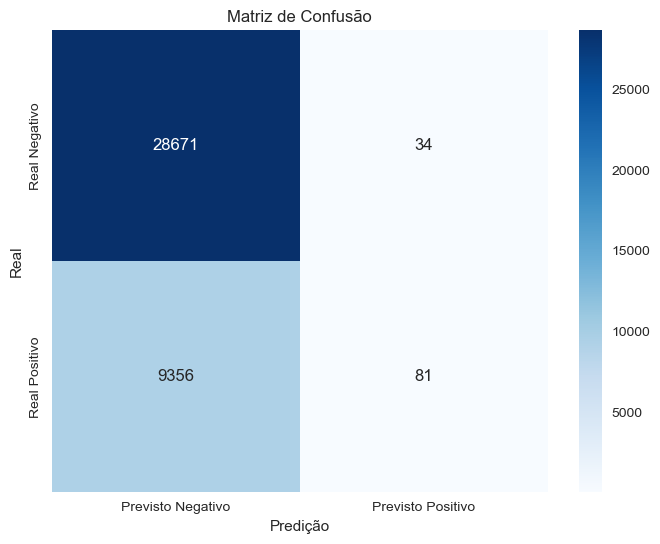

In [66]:
# Calculando a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)
print('Matriz de Confusão:\n', conf_matrix)

# Plotando a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Previsto Negativo', 'Previsto Positivo'], yticklabels=['Real Negativo', 'Real Positivo'])
plt.xlabel('Predição')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

In [67]:
# Definir os hiperparâmetros a serem testados
param_grid = {
    'penalty': ['l2'], # Deixei apenas l2 pra tentar evitar overfitting
    'C': [0.01, 0.1, 1, 10, 100, 1000, 10000, 100000], # Adicionei 1000 devido ao resultado de 100
    'solver': ['sag', 'saga'], # Deixei apenas sag e saga devido a quantidade de dados
    'max_iter': [300], # Essa quantidade de iterações está sendo suficiente para resolver
    'class_weight': [None, 'balanced'] # Adicionando class_weight
}

# Criando objeto para regressão (forma de bolo)
logistic_regression = LogisticRegression()

# Realizar a busca em grade (grid search) com validação cruzada
grid_search = GridSearchCV(estimator=logistic_regression, param_grid=param_grid, cv=3, scoring='recall')

# Usando o modelo e os dados de treino para treinar
grid_search.fit(X_train, y_train)

# Obter os melhores hiperparâmetros encontrados
best_params = grid_search.best_params_
print('Melhores Hiperparâmetros:', best_params)

# Avaliar o desempenho do modelo com os melhores hiperparâmetros
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculando a revocação
recall = recall_score(y_test, y_pred)
print('Recall com Melhores Hiperparâmetros:', recall)

# Calculando a acurácia
accuracy = accuracy_score(y_test, y_pred)
print('Acurácia com Melhores Hiperparâmetros:', accuracy)

Melhores Hiperparâmetros: {'C': 10, 'class_weight': 'balanced', 'max_iter': 300, 'penalty': 'l2', 'solver': 'sag'}
Recall com Melhores Hiperparâmetros: 0.8262159584613754
Acurácia com Melhores Hiperparâmetros: 0.6074406166430706


#### Resultados obtidos pela matriz confusão, usando recall como métrica.
#### Acertou muito mais inadimplentes e manteve um pouco dos acertos dos adimplentes. Ainda é um resultado bem ruim, mas está muito melhor do que usar a acurácia como métrica.
<br>

#### ACERTOS ADIMPLENTES: 0,53290367531788886953492422922836
#### ACERTOS INADIMPLENTES: 0,82727561725124509907809685281339

Matriz de Confusão:
 [[15372 13333]
 [ 1640  7797]]


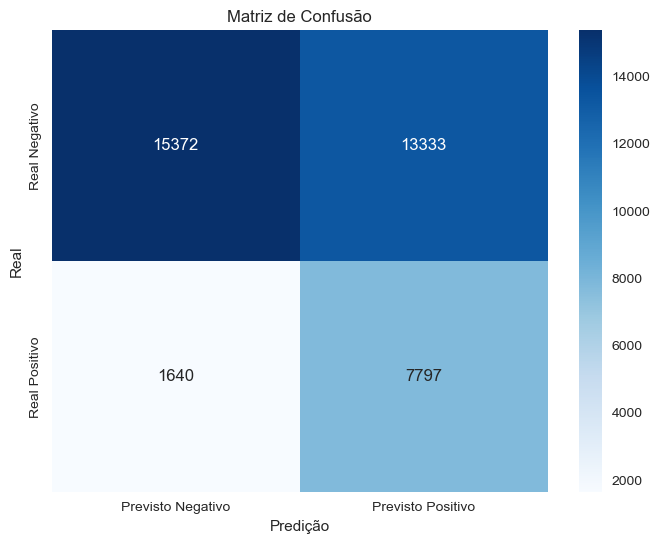

In [68]:
# Calculando a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)
print('Matriz de Confusão:\n', conf_matrix)

# Plotando a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Previsto Negativo', 'Previsto Positivo'], yticklabels=['Real Negativo', 'Real Positivo'])
plt.xlabel('Predição')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

#### Verificando várias métricas de uma vez

In [69]:
# Definir os hiperparâmetros a serem testados
param_grid = {
    'penalty': ['l2'], # Deixei apenas l2 pra tentar evitar overfitting
    'C': [0.01, 0.1, 1, 10, 100, 1000, 10000, 100000], # Adicionei 1000 devido ao resultado de 100
    'solver': ['sag', 'saga'], # Deixei apenas sag e saga devido a quantidade de dados
    'max_iter': [300], # Essa quantidade de iterações está sendo suficiente para resolver
    'class_weight': [None, 'balanced'] # Adicionando class_weight
}
scoring_metrics = {
    'recall': 'recall',
    'accuracy': 'accuracy',
    'f1': 'f1'
}

for metrics in scoring_metrics:
    # Criando objeto para regressão (forma de bolo)
    logistic_regression = LogisticRegression()

    # Realizar a busca em grade (grid search) com validação cruzada
    grid_search = GridSearchCV(estimator=logistic_regression, param_grid=param_grid, cv=2, scoring=metrics)

    # Usando o modelo e os dados de treino para treinar
    grid_search.fit(X_train, y_train)
    
    print(f'Métrica sendo avaliada: {metrics}\n')
    
    # Obter os melhores hiperparâmetros encontrados
    best_params = grid_search.best_params_
    print('Melhores Hiperparâmetros:', best_params)

    # Avaliar o desempenho do modelo com os melhores hiperparâmetros
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    # Calculando a revocação
    recall = recall_score(y_test, y_pred)
    print('Recall:', recall)

    # Calculando a acurácia
    accuracy = accuracy_score(y_test, y_pred)
    print('Acurácia:', accuracy)
    
    precision = precision_score(y_test, y_pred)
    print('Precisão:', precision)
    
    f1 = f1_score(y_test, y_pred)
    print('F1:', f1)
    
    # Calculando o Gini e o KS
    probabilities = best_model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, probabilities)
    gini_index = 2 * auc(fpr, tpr) - 1
    ks_statistic, _ = ks_2samp(probabilities[y_test == 1], probabilities[y_test == 0])
    print('Gini:', gini_index)
    print('KS:', ks_statistic)
    
    print('\n\n')

Métrica sendo avaliada: recall

Melhores Hiperparâmetros: {'C': 1, 'class_weight': 'balanced', 'max_iter': 300, 'penalty': 'l2', 'solver': 'sag'}
Recall: 0.8270636854932711
Acurácia: 0.6060772901263699
Precisão: 0.36819511274648553
F1: 0.5095479027256407
Gini: 0.5135381774426238
KS: 0.3838700330063133



Métrica sendo avaliada: accuracy

Melhores Hiperparâmetros: {'C': 1000, 'class_weight': None, 'max_iter': 300, 'penalty': 'l2', 'solver': 'sag'}
Recall: 0.009642894987813923
Acurácia: 0.7540506528236589
Precisão: 0.7222222222222222
F1: 0.01903168461779776
Gini: 0.5225887451316096
KS: 0.38970292213877866



Métrica sendo avaliada: f1

Melhores Hiperparâmetros: {'C': 100000, 'class_weight': 'balanced', 'max_iter': 300, 'penalty': 'l2', 'solver': 'sag'}
Recall: 0.8256861290664406
Acurácia: 0.6080698442661633
Precisão: 0.36935912021236256
F1: 0.5103985851373923
Gini: 0.5187544968819988
KS: 0.3867780054703939





#### REMOÇÃO DE VARIÁVEIS
<br>

#### Como visto anteriormente, varias variáveis tem um valor muito baixo de significância, sendo renda basicamente a única que realmente explica a variável resposta, para ter uma melhor noção desse impacto, foi feito um looping onde cada iteração é removido a coluna com menor Information Value e verificado o valor de Recall.

In [70]:
var_IV = list(dic_IV_ordenado.keys())
recall_dic = {}
df_modelar_significante = df_modelar_backup.copy()
removidas = []
best_model_backup = best_model

for var in reversed(var_IV): # Usando o reversed para pegar da menos significantes primeiro
    # Salvando uma lista das variáveis removidas para usar nos próximos loopings
    removidas.append(var)
    
    # Verificando se todas as variáveis foram removidas, exceto a última
    if len(removidas) == len(var_IV):
        break
    
    # Removendo as variáveis menos significantes
    df_modelar_significante = df_modelar_significante.drop(removidas, axis=1)
    
    # Fazendo One-Hot Enconding
    df_modelar_significante = pd.get_dummies(df_modelar_significante, columns=df_modelar_significante.select_dtypes(exclude=['int64', 'float64']).columns, drop_first=True)
   
    # Selecionar todas as colunas do tipo float e int
    # Tive de fazer assim pois chega um momento onde idade e tempo_emprego também são selecionados
    colunas_numericas = df_modelar_significante.select_dtypes(include=['float64', 'int64']).columns
    # Normalizar as colunas selecionadas
    df_modelar_significante[colunas_numericas] = scaler.fit_transform(df_modelar_significante[colunas_numericas])
    
    # Separando as variáveis explicativas e a alvo
    X = df_modelar_significante.drop('mau_True', axis=1)
    y = df_modelar_significante['mau_True']
    
    # Separando o conjunto de dados em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    
    # Usar o melhor modelo encontrado anteriormente
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)
    
    # Salvando os valores de recall e a variável removida
    recall_dic[var] = recall_score(y_test, y_pred)
    
        
    # Resetando o DataFrame para rodar novamente no looping
    df_modelar_significante = df_modelar_backup.copy()
    
print("Recall da Regressão Logística após remoção de cada variável menos renda:")
display(recall_dic)


Recall da Regressão Logística após remoção de cada variável menos renda:


{'posse_de_veiculo': 0.8262159584613754,
 'qtd_filhos': 0.8260040267034015,
 'qt_pessoas_residencia': 0.8265338560983363,
 'estado_civil': 0.8268517537352972,
 'tipo_residencia': 0.8270636854932711,
 'educacao': 0.8289710713150366,
 'tipo_renda': 0.8301366959838932,
 'sexo': 0.8311963547737629,
 'posse_de_imovel': 0.8316202182897107,
 'idade': 0.8315142524107237,
 'tempo_emprego': 0.8359648193281763}

In [71]:
# Selecionar as variáveis explicativas e a alvo
X = df_modelar[['renda']] 
y = df_modelar['mau_True']

# Separando o conjunto de dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Usar o melhor modelo encontrado anteriormente
best_model_backup.fit(X_train, y_train) # Usando o backup que ainda tem todas colunas
y_pred = best_model_backup.predict(X_test)

# Calculando a revocação
recall = recall_score(y_test, y_pred)
print('Recall com Melhores Hiperparâmetros:', recall)

# Calculando a acurácia
accuracy = accuracy_score(y_test, y_pred)
print('Acurácia com Melhores Hiperparâmetros:', accuracy)


# Calculando o Gini e o KS
probabilities = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, probabilities)
gini_index = 2 * auc(fpr, tpr) - 1
ks_statistic, _ = ks_2samp(probabilities[y_test == 1], probabilities[y_test == 0])
print('Gini:', gini_index)
print('KS:', ks_statistic)

Recall com Melhores Hiperparâmetros: 0.8336335699904631
Acurácia com Melhores Hiperparâmetros: 0.603796339992659
Gini: 0.5349427054249896
KS: 0.3953628880986474


## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

### Abaixo todas alterações feitas anteriormente no modelo in time.

In [72]:
df_oot = df[df['data_ref'] >= data_max - pd.DateOffset(months=3)]
df_oot = df_oot.drop(columns=['data_ref'])

# BALANCEAR #################################################################################
df_oot_1 = df_oot[df_oot['mau']==1]
n = df_oot_1.shape[0]*3 # Calculando 75% dos valores
df_oot_0 = df_oot[df_oot['mau'] == 0].sample(n=n)
df_oot = pd.concat([df_oot_1, df_oot_0])
############################################################################################

# MISSINGS ##################################################################################
df_oot = df_oot.fillna(df_oot['tempo_emprego'].mean())
############################################################################################

# OUTLIERS #################################################################################
# Calcula a média geral da coluna "renda"
media_geral = df_oot['renda'].mean()
n = len(df_oot)
# Lista para armazenar as diferenças
diferencas = []
# Itera sobre cada índice e valor na coluna "renda"
for i, valor in df_oot['renda'].iteritems():
    # Calcula a média excluindo o valor atual
    media_sem_valor = (n * media_geral - valor) / (n - 1)
    # Calcula a diferença entre a média sem o valor e a média geral
    diferenca = media_geral - media_sem_valor
    # Armazena a diferença e o índice correspondente
    diferencas.append((i, diferenca))
# Converte a lista de diferenças para um DataFrame
df_diferencas = pd.DataFrame(diferencas, columns=['indice', 'diferenca'])
# Calcule os valores mínimo e máximo da coluna 'diferenca'
min_diferenca = df_diferencas['diferenca'].min()
max_diferenca = df_diferencas['diferenca'].max()
# Normaliza as diferenças
df_diferencas['diferenca_normalizada'] = (df_diferencas['diferenca'] - min_diferenca) / (max_diferenca - min_diferenca)
# Identificar os índices dos outliers
outliers_indices = df_diferencas[df_diferencas['diferenca_normalizada'] > 0.08]['indice']
# Passando os indices a serem dropados
df_oot = df_oot.drop(outliers_indices)
############################################################################################

# AGRUPAMENTO ##############################################################################
df_oot['qt_pessoas_residencia'] = df_oot['qt_pessoas_residencia'].astype(int)
df_oot['qt_pessoas_residencia'].replace({6: '6+', 9: '6+', 15: '6+', 7: '6+'}, inplace=True)
df_oot['qtd_filhos'].replace({5: '5+', 7: '5+', 14: '5+'}, inplace=True)
df_oot['tipo_renda'].replace({'Bolsista': 'Assalariado'}, inplace=True)
df_oot['educacao'].replace({'Fundamental': 'Básico', 'Médio': 'Básico', 
                             'Superior incompleto': 'Avançado', 
                             'Superior completo': 'Avançado',
                             'Pós graduação': 'Avançado'}, inplace=True)
df_oot['tipo_residencia'].replace({'Estúdio': 'Outros', 'Comunitário': 'Outros', 
                                   'Governamental': 'Outros'}, inplace=True)
############################################################################################

# ONE HOT ENCODING #########################################################################
df_oot = pd.get_dummies(df_oot, columns=df_oot.select_dtypes(exclude=['int64', 'float64']).columns, drop_first=True)
############################################################################################


# NORMALIZAÇÃO #############################################################################
scaler = MinMaxScaler()
df_oot[quantitativas] = scaler.fit_transform(df_oot[quantitativas])
############################################################################################

df_oot

,idade,tempo_emprego,renda,sexo_M,posse_de_veiculo_S,posse_de_imovel_S,qtd_filhos_1,qtd_filhos_2,qtd_filhos_3,qtd_filhos_4,...,estado_civil_Viúvo,tipo_residencia_Casa,tipo_residencia_Com os pais,tipo_residencia_Outros,qt_pessoas_residencia_2,qt_pessoas_residencia_3,qt_pessoas_residencia_4,qt_pessoas_residencia_5,qt_pessoas_residencia_6+,mau_True
550006,0.52,0.09,0.02,0,1,1,1,0,0,0,...,0,1,0,0,0,1,0,0,0,1
550010,0.41,0.01,0.02,0,1,1,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1
550015,0.52,0.06,0.01,0,0,1,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1
550045,0.20,0.00,0.01,0,1,1,0,1,0,0,...,0,1,0,0,0,0,1,0,0,1
550046,0.52,0.09,0.01,0,0,1,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
741166,0.59,0.02,0.01,1,1,1,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
749146,0.48,0.17,0.05,1,1,1,1,0,0,0,...,0,1,0,0,1,0,0,0,0,0
681137,0.74,0.51,0.19,0,1,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
611060,0.26,0.08,0.05,1,0,1,1,0,0,0,...,0,1,0,0,0,1,0,0,0,0


In [73]:
# Separando as variáveis explicativas e a alvo
X = df_oot.drop('mau_True', axis=1)
y = df_oot['mau_True']

# Separando o conjunto de dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Usando o melhor modelo encontrado anteriormente (best_model_backup)
best_model_backup.fit(X_train, y_train)
y_pred = best_model_backup.predict(X_test)

# Calculando a revocação
recall = recall_score(y_test, y_pred)
print('Recall com Melhores Hiperparâmetros:', recall)

# Calculando a acurácia
accuracy = accuracy_score(y_test, y_pred)
print('Acurácia com Melhores Hiperparâmetros:', accuracy)

# Calculando o Gini e o KS
probabilities = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, probabilities)
gini_index = 2 * auc(fpr, tpr) - 1
ks_statistic, _ = ks_2samp(probabilities[y_test == 1], probabilities[y_test == 0])
print('Gini:', gini_index)
print('KS:', ks_statistic)

Recall com Melhores Hiperparâmetros: 0.8059925093632959
Acurácia com Melhores Hiperparâmetros: 0.5908034424272881
Gini: 0.46572989173135726
KS: 0.34667719572458217


#### RESULTADOS APENAS DA COLUNA RENDA

In [74]:
# Selecionar as variáveis explicativas e a alvo
X = df_oot[['renda']] 
y = df_oot['mau_True']

# Separando o conjunto de dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Usar o melhor modelo encontrado anteriormente
best_model_backup.fit(X_train, y_train) # Usando o backup que ainda tem todas colunas
y_pred = best_model_backup.predict(X_test)

# Calculando a revocação
recall = recall_score(y_test, y_pred)
print('Recall com Melhores Hiperparâmetros:', recall)

# Calculando a acurácia
accuracy = accuracy_score(y_test, y_pred)
print('Acurácia com Melhores Hiperparâmetros:', accuracy)


# Calculando o Gini e o KS
probabilities = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, probabilities)
gini_index = 2 * auc(fpr, tpr) - 1
ks_statistic, _ = ks_2samp(probabilities[y_test == 1], probabilities[y_test == 0])
print('Gini:', gini_index)
print('KS:', ks_statistic)

Recall com Melhores Hiperparâmetros: 0.8235955056179776
Acurácia com Melhores Hiperparâmetros: 0.5823230102393366
Gini: 0.4787944427783217
KS: 0.34935367009133494


### Conclusões
<br>

#### Como esperado varias colunas não foram muito relevantes para resolução do problema, praticamente apenas a coluna renda já obtendo um resultado similar frente a todas outras variáveis. Foi explorado variás métricas e modificações dos dados, mas o resultado ainda não ficou satisfatório, faltando apenas a comparação com outros modelos de classificação, como random forest e comparação das métricas pedidas.

# MODULO 38, CONTINUAÇÃO...

In [75]:
# Definindo um novo DF para treinar o Pipeline
df_cru = df.copy()
df_cru = df_cru.drop(columns=['data_ref'])
df_cru

,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.87,1.00,2515.39,False
1,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.53,2.00,3180.19,False
2,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.24,4.00,1582.29,False
3,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.77,2.00,13721.17,False
4,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.43,1.00,2891.08,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,M,N,S,0,Empresário,Superior completo,Casado,Casa,48,3.04,2.00,2109.99,False
749996,F,N,S,0,Pensionista,Médio,Solteiro,Casa,65,NaN,1.00,1389.39,False
749997,M,S,N,2,Assalariado,Médio,Casado,Casa,43,10.38,4.00,649.06,True
749998,F,N,S,0,Assalariado,Médio,Viúvo,Casa,56,13.78,1.00,4216.72,True


# a - Criar um pipeline utilizando o sklearn pipeline para o preprocessamento 

## Pré processamento

### Funções para serem encadeadas no pipeline

In [76]:
# Só lembrando que existem essas variáveis
'''quantitativas = ['tempo_emprego', 'idade', 'renda']
qualitativas = ['qt_pessoas_residencia', 'qtd_filhos', 'tipo_renda', 'educacao', 'tipo_residencia']'''

"quantitativas = ['tempo_emprego', 'idade', 'renda']\nqualitativas = ['qt_pessoas_residencia', 'qtd_filhos', 'tipo_renda', 'educacao', 'tipo_residencia']"

In [84]:
# Função para balancear quantidade de adimplentes e inadimplentes
def balanceamento(df): # Recebe um DataFrame
    df_1 = df[df['mau'] == 1] # Define apenas inadimplentes
    n = df_1.shape[0] * 3 # Pega a quantidade de inadimplentes e multiplica por 3 para usar nos adimplentes
    df_0 = df[df['mau'] == 0].sample(n=n, random_state=0) # Define adimplentes 3x mais que inadimplentes
    return pd.concat([df_1, df_0]).sample(frac=1, random_state=0).reset_index(drop=True) # Junta adimplentes e inadimplentes 75% e 25%
# o frac=1 é para embaralhar os dados e não inviesar o modelo

# Função para preenchimento de valores ausentes pela média
def preencher_missings(df): # Recebe um DataFrame
    df['tempo_emprego'].fillna(df['tempo_emprego'].mean(), inplace=True) # Preenche missing com médias
    return df

def remove_outliers_renda(df, z_thresh=3):
    col = 'renda'
    col_zscore = (df[col] - df[col].mean()) / df[col].std()
    df = df[(col_zscore.abs() <= z_thresh)]
    return df

# Função para agrupar categorias
def agrupar_categorias(df):
    df['qt_pessoas_residencia'] = df['qt_pessoas_residencia'].astype(int)
    df['qt_pessoas_residencia'].replace({6: '6+', 9: '6+', 15: '6+', 7: '6+'}, inplace=True)
    df['qtd_filhos'].replace({5: '5+', 7: '5+', 14: '5+'}, inplace=True)
    df['tipo_renda'].replace({'Bolsista': 'Assalariado'}, inplace=True)
    df['educacao'].replace({'Fundamental': 'Básico', 'Médio': 'Básico', 
                            'Superior incompleto': 'Avançado', 
                            'Superior completo': 'Avançado',
                            'Pós graduação': 'Avançado'}, inplace=True)
    df['tipo_residencia'].replace({'Estúdio': 'Outros', 'Comunitário': 'Outros', 
                                   'Governamental': 'Outros'}, inplace=True)
    return df


def one_hot_encoding(df):
    df = pd.get_dummies(df, columns=qualitativas, drop_first=True)
    return df


def min_max_scaler(df):
    scaler = MinMaxScaler()
    df[quantitativas] = scaler.fit_transform(df[quantitativas])
    return df
    
# Função para aplicar o PCA e retornar um DataFrame
def aplicar_pca(df):
    pca = PCA(n_components=5)  # Ajuste o número de componentes
    principal_components = pca.fit_transform(df) # Capturando os componentes principais
    pca_df = pd.DataFrame(data=principal_components, index=df.index) # Transformando de volta para DF
    return pca_df

    
pipeline = Pipeline(steps=[
    ('balanceamento', FunctionTransformer(balanceamento)), 
    ('preencher_missings', FunctionTransformer(preencher_missings)),  # Preenchimento de valores ausentes com a média
    ('remove_outliers_renda', FunctionTransformer(remove_outliers_renda)),
    ('agrupar_categorias', FunctionTransformer(agrupar_categorias)),
    ('one_hot_encoding', FunctionTransformer(one_hot_encoding)),
    ('min_max_scaler', FunctionTransformer(min_max_scaler)),
    #('aplicar_pca', FunctionTransformer(aplicar_pca))
])



In [85]:
# Aplicando o pipeline
df_transformed = pipeline.fit_transform(df_cru)
df_transformed

,idade,tempo_emprego,renda,mau,sexo_M,posse_de_veiculo_S,posse_de_imovel_S,qtd_filhos_1,qtd_filhos_2,qtd_filhos_3,...,estado_civil_União,estado_civil_Viúvo,tipo_residencia_Casa,tipo_residencia_Com os pais,tipo_residencia_Outros,qt_pessoas_residencia_2,qt_pessoas_residencia_3,qt_pessoas_residencia_4,qt_pessoas_residencia_5,qt_pessoas_residencia_6+
0,0.30,0.16,0.04,False,1,1,0,1,0,0,...,0,0,1,0,0,0,1,0,0,0
1,0.28,0.22,0.02,False,1,1,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0.07,0.11,0.02,False,0,0,1,0,0,0,...,1,0,1,0,0,1,0,0,0,0
3,0.22,0.07,0.02,False,0,0,0,1,0,0,...,0,0,1,0,0,0,1,0,0,0
4,0.11,0.13,0.01,False,1,1,1,0,0,0,...,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234567,0.91,0.16,0.00,False,1,1,1,0,0,0,...,1,0,1,0,0,1,0,0,0,0
234568,0.74,0.16,0.04,False,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
234569,0.41,0.20,0.08,False,1,1,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
234570,0.22,0.04,0.00,True,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


#### Provando que deu certo o balanceamento

In [86]:
adimplentes = df_transformed[df_transformed['mau']==False].shape[0]
inadimplentes = df_transformed[df_transformed['mau']==True].shape[0]
print(f"Proporção adimplentes: {(adimplentes/df_transformed.shape[0])*100}")
print(f"Proporção inadimplentes: {(inadimplentes/df_transformed.shape[0])*100}")


Proporção adimplentes: 74.74206597080122
Proporção inadimplentes: 25.25793402919878


#### Provando que deu certo o tratamento de missings

In [87]:
print(df_transformed.isnull().sum())

idade                          0
tempo_emprego                  0
renda                          0
mau                            0
sexo_M                         0
posse_de_veiculo_S             0
posse_de_imovel_S              0
qtd_filhos_1                   0
qtd_filhos_2                   0
qtd_filhos_3                   0
qtd_filhos_4                   0
qtd_filhos_5+                  0
tipo_renda_Empresário          0
tipo_renda_Pensionista         0
tipo_renda_Servidor público    0
educacao_Básico                0
estado_civil_Separado          0
estado_civil_Solteiro          0
estado_civil_União             0
estado_civil_Viúvo             0
tipo_residencia_Casa           0
tipo_residencia_Com os pais    0
tipo_residencia_Outros         0
qt_pessoas_residencia_2        0
qt_pessoas_residencia_3        0
qt_pessoas_residencia_4        0
qt_pessoas_residencia_5        0
qt_pessoas_residencia_6+       0
dtype: int64


#### Comparando antes e depois da remoção de outliers pelo Pipeline

#### Obs: Não foi usado o mesmo método que antes pois o método que usei foi pessoal e não usado de maneira geral, além dos resultados serem extremamente similares a três vezes o desvio padrão usando o valor Z.

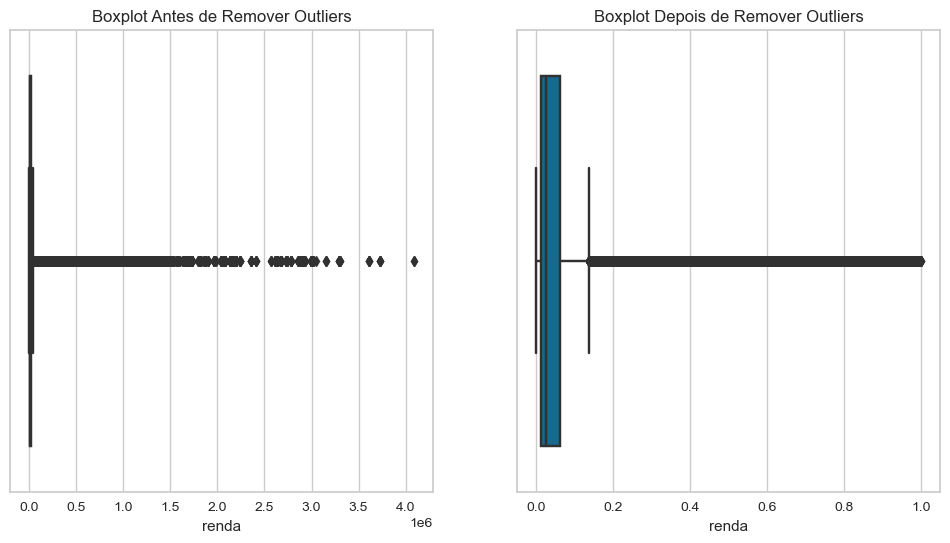

In [88]:
# Boxplots antes e depois de remover outliers
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(data=df_cru, x='renda')
plt.title('Boxplot Antes de Remover Outliers')

plt.subplot(1, 2, 2)
sns.boxplot(data=df_transformed, x='renda')
plt.title('Boxplot Depois de Remover Outliers')

plt.show()

#### Provando que o agrupamento e o One-hot Encoding deu certo

In [89]:
df_transformed.dtypes

idade                          float64
tempo_emprego                  float64
renda                          float64
mau                               bool
sexo_M                           uint8
posse_de_veiculo_S               uint8
posse_de_imovel_S                uint8
qtd_filhos_1                     uint8
qtd_filhos_2                     uint8
qtd_filhos_3                     uint8
qtd_filhos_4                     uint8
qtd_filhos_5+                    uint8
tipo_renda_Empresário            uint8
tipo_renda_Pensionista           uint8
tipo_renda_Servidor público      uint8
educacao_Básico                  uint8
estado_civil_Separado            uint8
estado_civil_Solteiro            uint8
estado_civil_União               uint8
estado_civil_Viúvo               uint8
tipo_residencia_Casa             uint8
tipo_residencia_Com os pais      uint8
tipo_residencia_Outros           uint8
qt_pessoas_residencia_2          uint8
qt_pessoas_residencia_3          uint8
qt_pessoas_residencia_4  

#### Provando que deu certo o scale

In [90]:
df_transformed[quantitativas]

,idade,tempo_emprego,renda
0,0.30,0.16,0.04
1,0.28,0.22,0.02
2,0.07,0.11,0.02
3,0.22,0.07,0.02
4,0.11,0.13,0.01
...,...,...,...
234567,0.91,0.16,0.00
234568,0.74,0.16,0.04
234569,0.41,0.20,0.08
234570,0.22,0.04,0.00


## Todas as questões abaixo foram resolvidas diretamente no Pipeline executado
<br>

#### Obs: Não foi aplicado Feature Importance devido a natureza dos dados, onde foi calculado que apenas a renda já explica a grande maior parte e ainda por cima teria o PCA para fazer a junção das variáveis.

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance? 

### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1. 
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

# b - Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.


In [99]:
# Configurações iniciais dos classificadores
clf = setup(data=df_transformed, 
            target='mau', 
            session_id=123, # Salvando estado
            fold_strategy='stratifiedkfold', 
            fold=5, # Definindo quantidade de Folds
            use_gpu=True) # Usa GPU para ajudar o processamento

# Comparar modelos
best_model = compare_models(sort='Recall')
best_model

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Ellesmere, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet th

[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Ellesmere, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet th

[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because

,Description,Value
0,Session id,123
1,Target,mau
2,Target type,Binary
3,Original data shape,"(232133, 28)"
4,Transformed data shape,"(232133, 28)"
5,Transformed train set shape,"(162493, 28)"
6,Transformed test set shape,"(69640, 28)"
7,Numeric features,27
8,Preprocess,True
9,Imputation type,simple


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Ellesmere, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet th

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.5809,0.6755,0.7651,0.3498,0.4797,0.2038,0.2485,0.2660
qda,Quadratic Discriminant Analysis,0.5581,0.6762,0.4800,0.3269,0.2824,0.0596,0.0883,0.3720
rf,Random Forest Classifier,0.7209,0.6963,0.3756,0.4387,0.4047,0.2239,0.2250,5.1060
knn,K Neighbors Classifier,0.7429,0.6923,0.3442,0.4875,0.4035,0.2458,0.2519,13.6820
et,Extra Trees Classifier,0.7161,0.6332,0.3442,0.4237,0.3798,0.1983,0.2001,5.8500
dt,Decision Tree Classifier,0.7104,0.6175,0.3345,0.4100,0.3684,0.1830,0.1846,1.5180
lightgbm,Light Gradient Boosting Machine,0.7783,0.7783,0.3104,0.6227,0.4143,0.2960,0.3233,2.9420
gbc,Gradient Boosting Classifier,0.7786,0.7791,0.3066,0.6262,0.4116,0.2945,0.3230,16.6080
ada,Ada Boost Classifier,0.7782,0.7780,0.2805,0.6398,0.3894,0.2785,0.3141,4.7340
lr,Logistic Regression,0.7485,0.7707,0.0063,0.7599,0.0125,0.0084,0.0525,0.7120


GaussianNB(priors=None, var_smoothing=1e-09)

### Criando um modelo para rodar o Light GBM

In [95]:
lightgbm_model = create_model('lightgbm')
lightgbm_model

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7759,0.7778,0.3109,0.6105,0.4120,0.2912,0.3165
1,0.7772,0.7777,0.3099,0.6175,0.4127,0.2934,0.3199
2,0.7812,0.7807,0.3089,0.6381,0.4163,0.3011,0.3312
3,0.7812,0.7776,0.3177,0.6333,0.4232,0.3061,0.3338
4,0.7821,0.7819,0.3250,0.6340,0.4298,0.3120,0.3386
5,0.7804,0.7801,0.3170,0.6294,0.4216,0.3039,0.3311
6,0.7754,0.7735,0.3012,0.6128,0.4039,0.2848,0.3121
7,0.7828,0.7865,0.3170,0.6418,0.4244,0.3090,0.3382
8,0.7733,0.7730,0.2995,0.6030,0.4002,0.2794,0.3055


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [102]:
evaluate_model(best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [103]:
# Ajustar o melhor modelo para melhorar o desempenho
tuned_model = tune_model(best_model, optimize='Recall')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5771,0.6787,0.7954,0.3512,0.4872,0.2106,0.2624
1,0.5763,0.6717,0.7679,0.3470,0.4780,0.1994,0.2446
2,0.5539,0.6783,0.8070,0.3390,0.4775,0.1890,0.2443
3,0.6026,0.6779,0.7275,0.3587,0.4804,0.2148,0.2503
4,0.5944,0.6709,0.7276,0.3530,0.4754,0.2049,0.2409
Mean,0.5809,0.6755,0.7651,0.3498,0.4797,0.2037,0.2485
Std,0.0169,0.0035,0.0332,0.0065,0.0041,0.0090,0.0076


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


### Mostra as predições incluindo as colunas prediction_label e prediction_score

In [105]:
predictions = predict_model(tuned_model)
predictions

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Naive Bayes,0.5774,0.6730,0.7657,0.3473,0.4779,0.1998,0.2444


,idade,tempo_emprego,renda,sexo_M,posse_de_veiculo_S,posse_de_imovel_S,qtd_filhos_1,qtd_filhos_2,qtd_filhos_3,qtd_filhos_4,...,tipo_residencia_Com os pais,tipo_residencia_Outros,qt_pessoas_residencia_2,qt_pessoas_residencia_3,qt_pessoas_residencia_4,qt_pessoas_residencia_5,qt_pessoas_residencia_6+,mau,prediction_label,prediction_score
106881,0.65,0.06,0.01,1,1,0,0,0,0,0,...,0,0,1,0,0,0,0,True,1,0.62
71907,0.22,0.17,0.07,0,0,0,1,0,0,0,...,1,0,0,1,0,0,0,False,1,0.92
196114,0.41,0.16,0.03,1,1,1,1,0,0,0,...,0,0,0,1,0,0,0,False,1,0.61
155524,0.22,0.20,0.04,1,1,0,0,0,0,0,...,0,0,1,0,0,0,0,False,1,0.56
136225,0.11,0.09,0.01,1,0,1,0,1,0,0,...,0,0,0,0,1,0,0,False,1,0.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73363,0.15,0.06,0.03,0,0,1,0,1,0,0,...,0,0,0,0,1,0,0,False,1,0.58
79346,0.50,0.25,0.21,0,1,0,1,0,0,0,...,0,0,1,0,0,0,0,False,0,1.00
222355,0.28,0.01,0.01,1,0,1,1,0,0,0,...,0,0,1,0,0,0,0,True,1,0.65
210796,0.41,0.21,0.06,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,False,0,0.66
